<H1>Load Datasets<H1>

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')


path = os.getcwd()

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

bracket_training = pd.read_csv(f"{path}/bracket_training.csv", sep= ",")
# bracket_training

bracket_test = pd.read_csv(f'{path}/bracket_test.csv')

college_info = pd.read_csv(f'{path}/institutions.csv', sep = ',', encoding= 'utf-8')

df_kenpom = pd.read_csv('Kenpom Data.csv')

distances_ew_df = pd.read_csv(f'{path}/SemifinalWinner_East_West.csv', sep = '|')


# --- Step 1: Extract the full team name (excluding the trailing seed rank)
# Instead of taking only the first token, we remove the last token (which is the seed rank)
df_kenpom['Team_Name'] = df_kenpom['Team'].apply(lambda x: ' '.join(x.split()[:-1]))

# --- Step 2: Apply manual corrections to match college_info['Institution_Name']
# Mapping dictionary: keys are the names extracted from KenPom and values are the correct names from college_info.
mapping = {
    # Changes applied:
    "Connecticut": "UConn",            # "Connecticut" → "UConn"
    "Houston": "Houston",              # No change needed
    "Purdue": "Purdue",                # No change needed
    "Auburn": "Auburn",                # No change needed
    "Tennessee": "Tennessee",          # No change needed
    "Arizona": "Arizona",              # No change needed
    "Duke": "Duke",                    # No change needed
    "Iowa St.": "Iowa St.",             # No change needed
    "North Carolina": "North Carolina",# No change needed
    "Illinois": "Illinois",            # No change needed
    "Creighton": "Creighton",          # No change needed
    "Gonzaga": "Gonzaga",              # No change needed
    "Marquette": "Marquette",          # No change needed
    "Alabama": "Alabama",              # No change needed
    "Baylor": "Baylor",                # No change needed
    "Michigan St.": "Michigan St.",     # No change needed
    "Wisconsin": "Wisconsin",          # No change needed
    "BYU": "BYU",                      # No change needed
    "Clemson": "Clemson",              # No change needed
    "Saint Mary's": "Saint Mary's",    # No change needed
    "San Diego St.": "San Diego St.",   # No change needed
    "Kentucky": "Kentucky",            # No change needed
    "Colorado": "Colorado",            # No change needed
    "Texas": "Texas",                  # No change needed
    "Florida": "Florida",              # No change needed
    "Kansas": "Kansas",                # No change needed
    "New Mexico": "New Mexico",        # No change needed
    "Nebraska": "Nebraska",            # No change needed
    "Texas Tech": "Texas Tech",        # No change needed
    "Dayton": "Dayton",                # No change needed
    "Mississippi St.": "Mississippi St.",# No change needed
    "Texas A&M": "Texas A&M",          # No change needed
    "Colorado St.": "Colorado St.",    # No change needed
    "Nevada": "Nevada",                # No change needed
    "Northwestern": "Northwestern",    # No change needed
    "Washington St.": "Washington St.",# No change needed
    "TCU": "TCU",                    # No change needed
    "Boise St.": "Boise St.",          # No change needed
    "N.C. State": "NC State",          # "N.C. State" → "NC State" (remove periods)
    "Florida Atlantic": "FAU",         # "Florida Atlantic" → "FAU"
    "Utah St.": "Utah St.",            # No change needed
    "Grand Canyon": "Grand Canyon",    # No change needed
    "Drake": "Drake",                  # No change needed
    "South Carolina": "South Carolina",# No change needed
    "Oregon": "Oregon",                # No change needed
    "James Madison": "James Madison",  # No change needed
    "McNeese St.": "McNeese",           # "McNeese St." → "McNeese"
    "Virginia": "Virginia",            # No change needed
    "Samford": "Samford",              # No change needed
    "Duquesne": "Duquesne",            # No change needed
    "Yale": "Yale",                    # No change needed
    "Charleston": "Charleston",        # No change needed
    "Vermont": "Vermont",              # No change needed
    "UAB": "UAB",                      # No change needed
    "Morehead St.": "Morehead St.",     # No change needed
    "Akron": "Akron",                  # No change needed
    "Oakland": "Oakland",              # No change needed
    "Western Kentucky": "Western Ky.", # "Western Kentucky" → "Western Ky."
    "South Dakota St.": "South Dakota St.",# No change needed
    "Colgate": "Colgate",              # No change needed
    "Longwood": "Longwood",            # No change needed
    "Long Beach St.": "Long Beach St.",# No change needed
    "Saint Peter's": "Saint Peter's",  # No change needed
    "Stetson": "Stetson",              # No change needed
    "Montana St.": "Montana St.",      # No change needed
    "Grambling St.": "Grambling St.",    # No change needed
    "Howard": "Howard",                # No change needed
    "Wagner": "Wagner"                 # No change needed
}

# Apply the mapping so that each Team_Name matches college_info['Institution_Name']
df_kenpom['Team_Name'] = df_kenpom['Team_Name'].map(mapping)

# --- Step 3: Process the Seed_Rank column
df_kenpom['Seed_Rank'] = df_kenpom['Team'].str.extract(r'(\d+)$')
df_kenpom = df_kenpom.dropna(subset=['Seed_Rank'])
df_kenpom['Seed_Rank'] = df_kenpom['Seed_Rank'].astype(int)

# Create a cleaned DataFrame with selected columns and set index as Team_Name
df_ken_clean = df_kenpom.loc[:, ['Rk', 'Team_Name', 'Seed_Rank', 'NetRtg', 'Luck']]
df_ken_clean = df_ken_clean.set_index('Team_Name')

# --- Step 4: Merge with the college_info dataset
# Now, set the index of college_info to 'Institution_Name' to match
college_info_ken_df = college_info.join(df_ken_clean, how='left', on='InstitutionName')

#Fast way to create new columns
college_info_ken_df['win_%'] = college_info_ken_df['RegularSeasonWins']/ (college_info_ken_df['RegularSeasonWins'] + college_info_ken_df['RegularSeasonLosses'])

#Join Ken info to bracket training and bracket test
college_info_ken_df = college_info_ken_df.set_index('InstitutionID')
train_df = bracket_training.join(
    college_info_ken_df.add_prefix("W_"), on="RegionWinner_West"
).join(
    college_info_ken_df.add_prefix("E_"), on="RegionWinner_East"
).join(
    college_info_ken_df.add_prefix('M_'), on="RegionWinner_Midwest"
).join(
    college_info_ken_df.add_prefix('S_'), on='RegionWinner_South'
)

test_df = bracket_test.join(
    college_info_ken_df.add_prefix("W_"), on="RegionWinner_West"
).join(
    college_info_ken_df.add_prefix("E_"), on="RegionWinner_East"
).join(
    college_info_ken_df.add_prefix('M_'), on="RegionWinner_Midwest"
).join(
    college_info_ken_df.add_prefix('S_'), on='RegionWinner_South'
)

classic1_df_train = train_df[
    [
        'CustomerID',
        #'CustomerAreaCode', 'CustomerPostalCode',
       'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude',
       'CustomerDMACode',
        'CustomerDMADescription',
       'NCAACustomerRecordCreated', 'BracketEntryId',
       'BracketEntryCreatedDate', 'RegionWinner_East', 'RegionWinner_West',
       'RegionWinner_South', 'RegionWinner_Midwest',
       'SemifinalWinner_East_West', 'SemifinalWinner_South_Midwest',
       'NationalChampion',
       'E_InstitutionName',
        # 'E_InstitutionNickname',
        #'E_InstitutionAbbreviation', 'E_InstitutionCity',
        #'E_InstitutionState', 'E_InstitutionPostalCode',
       'E_InstitutionDMACode',
        # 'E_InstitutionDMADescription',
       'E_InstitutionLatitude', 'E_InstitutionLongitude',
       'E_InstitutionConference', 'E_InstitutionEnrollment_Male',
       'E_InstitutionEnrollment_Female', 'E_InstitutionEnrollment_Total',
       'E_InstitutionNCAAMemberSinceDate', 'E_RegularSeasonWins',
       'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance',
       'E_RegularSeasonAverageScore',
       'E_Rk',
       'E_Seed_Rank', 'E_NetRtg', 'E_Luck',
       'M_InstitutionName',
        # 'M_InstitutionNickname',
        #'M_InstitutionAbbreviation', 'M_InstitutionCity',
        #'M_InstitutionState', 'M_InstitutionPostalCode',
       'M_InstitutionDMACode',
        # 'M_InstitutionDMADescription',
       'M_InstitutionLatitude', 'M_InstitutionLongitude',
       'M_InstitutionConference', 'M_InstitutionEnrollment_Male',
       'M_InstitutionEnrollment_Female', 'M_InstitutionEnrollment_Total',
       'M_InstitutionNCAAMemberSinceDate', 'M_RegularSeasonWins',
       'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance',
       'M_RegularSeasonAverageScore',
       'M_Rk',
       'M_Seed_Rank', 'M_NetRtg', 'M_Luck',
       'S_InstitutionName',
        # 'S_InstitutionNickname',
        #'S_InstitutionAbbreviation', 'S_InstitutionCity',
        #'S_InstitutionState', 'S_InstitutionPostalCode',
       'S_InstitutionDMACode',
        # 'S_InstitutionDMADescription',
       'S_InstitutionLatitude', 'S_InstitutionLongitude',
       'S_InstitutionConference', 'S_InstitutionEnrollment_Male',
       'S_InstitutionEnrollment_Female', 'S_InstitutionEnrollment_Total',
       'S_InstitutionNCAAMemberSinceDate', 'S_RegularSeasonWins',
       'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance',
       'S_RegularSeasonAverageScore',
       'S_Rk',
       'S_Seed_Rank', 'S_NetRtg', 'S_Luck',
       'W_InstitutionName',
        #'W_InstitutionNickname', 'W_InstitutionAbbreviation',
        #'W_InstitutionCity', 'W_InstitutionState', 'W_InstitutionPostalCode',
       'W_InstitutionDMACode',
        #'W_InstitutionDMADescription',
       'W_InstitutionLatitude', 'W_InstitutionLongitude',
       'W_InstitutionConference',
       'W_InstitutionEnrollment_Male',
       'W_InstitutionEnrollment_Female', 'W_InstitutionEnrollment_Total',
       'W_InstitutionNCAAMemberSinceDate', 'W_RegularSeasonWins',
       'W_RegularSeasonLosses', 'W_RegularSeasonAverageAttendance',
       'W_RegularSeasonAverageScore',
       'W_Rk',
       'W_Seed_Rank', 'W_NetRtg', 'W_Luck',
    ]
]

classic1_df_test = test_df[
    [
        'CustomerID',
        #'CustomerAreaCode', 'CustomerPostalCode',
       'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude',
       'CustomerDMACode',
        'CustomerDMADescription',
       'NCAACustomerRecordCreated', 'BracketEntryId',
       'BracketEntryCreatedDate', 'RegionWinner_East', 'RegionWinner_West',
       'RegionWinner_South', 'RegionWinner_Midwest',
       'E_InstitutionName',
        # 'E_InstitutionNickname',
        #'E_InstitutionAbbreviation', 'E_InstitutionCity',
        #'E_InstitutionState', 'E_InstitutionPostalCode',
       'E_InstitutionDMACode',
        # 'E_InstitutionDMADescription',
       'E_InstitutionLatitude', 'E_InstitutionLongitude',
       'E_InstitutionConference', 'E_InstitutionEnrollment_Male',
       'E_InstitutionEnrollment_Female', 'E_InstitutionEnrollment_Total',
       'E_InstitutionNCAAMemberSinceDate', 'E_RegularSeasonWins',
       'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance',
       'E_RegularSeasonAverageScore',
       'E_Rk',
       'E_Seed_Rank', 'E_NetRtg', 'E_Luck',
       'M_InstitutionName',
        # 'M_InstitutionNickname',
        #'M_InstitutionAbbreviation', 'M_InstitutionCity',
        #'M_InstitutionState', 'M_InstitutionPostalCode',
       'M_InstitutionDMACode',
        # 'M_InstitutionDMADescription',
       'M_InstitutionLatitude', 'M_InstitutionLongitude',
       'M_InstitutionConference', 'M_InstitutionEnrollment_Male',
       'M_InstitutionEnrollment_Female', 'M_InstitutionEnrollment_Total',
       'M_InstitutionNCAAMemberSinceDate', 'M_RegularSeasonWins',
       'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance',
       'M_RegularSeasonAverageScore',
       'M_Rk',
       'M_Seed_Rank', 'M_NetRtg', 'M_Luck',
       'S_InstitutionName',
        # 'S_InstitutionNickname',
        #'S_InstitutionAbbreviation', 'S_InstitutionCity',
        #'S_InstitutionState', 'S_InstitutionPostalCode',
       'S_InstitutionDMACode',
        # 'S_InstitutionDMADescription',
       'S_InstitutionLatitude', 'S_InstitutionLongitude',
       'S_InstitutionConference', 'S_InstitutionEnrollment_Male',
       'S_InstitutionEnrollment_Female', 'S_InstitutionEnrollment_Total',
       'S_InstitutionNCAAMemberSinceDate', 'S_RegularSeasonWins',
       'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance',
       'S_RegularSeasonAverageScore',
       'S_Rk',
       'S_Seed_Rank', 'S_NetRtg', 'S_Luck',
       'W_InstitutionName',
        #'W_InstitutionNickname', 'W_InstitutionAbbreviation',
        #'W_InstitutionCity', 'W_InstitutionState', 'W_InstitutionPostalCode',
       'W_InstitutionDMACode',
        #'W_InstitutionDMADescription',
       'W_InstitutionLatitude', 'W_InstitutionLongitude',
       'W_InstitutionConference',
       'W_InstitutionEnrollment_Male',
       'W_InstitutionEnrollment_Female', 'W_InstitutionEnrollment_Total',
       'W_InstitutionNCAAMemberSinceDate', 'W_RegularSeasonWins',
       'W_RegularSeasonLosses', 'W_RegularSeasonAverageAttendance',
       'W_RegularSeasonAverageScore',
       'W_Rk',
       'W_Seed_Rank', 'W_NetRtg', 'W_Luck',
    ]
]

# Create separate imputers:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

# List the columns to impute:
num_cols = ['CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude']
cat_cols = ['CustomerDMACode', 'CustomerDMADescription']

# Impute in the training set using .loc:
classic1_df_train.loc[:, num_cols] = num_imputer.fit_transform(classic1_df_train.loc[:, num_cols])
classic1_df_train.loc[:, cat_cols] = cat_imputer.fit_transform(classic1_df_train.loc[:, cat_cols])

# And in the test set using .loc:
classic1_df_test.loc[:, num_cols] = num_imputer.transform(classic1_df_test.loc[:, num_cols])
classic1_df_test.loc[:, cat_cols] = cat_imputer.transform(classic1_df_test.loc[:, cat_cols])

num_brackets_df_train = classic1_df_train.groupby(by = 'CustomerID').agg(bracket_entry_count= pd.NamedAgg(column = "BracketEntryId", aggfunc = 'count'))
num_brackets_df_test = classic1_df_test.groupby(by = 'CustomerID').agg(bracket_entry_count= pd.NamedAgg(column = "BracketEntryId", aggfunc = 'count'))


classic1_df_train['m_win_%'] = classic1_df_train['M_RegularSeasonWins']/ (classic1_df_train['M_RegularSeasonWins'] + classic1_df_train['M_RegularSeasonLosses'])
classic1_df_train['s_win_%'] = classic1_df_train['S_RegularSeasonWins']/ (classic1_df_train['S_RegularSeasonWins'] + classic1_df_train['S_RegularSeasonLosses'])
classic1_df_train['e_win_%'] = classic1_df_train['E_RegularSeasonWins']/ (classic1_df_train['E_RegularSeasonWins'] + classic1_df_train['E_RegularSeasonLosses'])
classic1_df_train['w_win_%'] = classic1_df_train['W_RegularSeasonWins']/ (classic1_df_train['W_RegularSeasonWins'] + classic1_df_train['W_RegularSeasonLosses'])

classic1_df_test['m_win_%'] = classic1_df_test['M_RegularSeasonWins']/ (classic1_df_test['M_RegularSeasonWins'] + classic1_df_test['M_RegularSeasonLosses'])
classic1_df_test['s_win_%'] = classic1_df_test['S_RegularSeasonWins']/ (classic1_df_test['S_RegularSeasonWins'] + classic1_df_test['S_RegularSeasonLosses'])
classic1_df_test['e_win_%'] = classic1_df_test['E_RegularSeasonWins']/ (classic1_df_test['E_RegularSeasonWins'] + classic1_df_test['E_RegularSeasonLosses'])
classic1_df_test['w_win_%'] = classic1_df_test['W_RegularSeasonWins']/ (classic1_df_test['W_RegularSeasonWins'] + classic1_df_test['W_RegularSeasonLosses'])



In [ ]:
# Model Two Classifiers with Pipelines (Random Forest & Logistic Regression)
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.linear_model import LassoCV, LogisticRegressionCV

# Define the closeness function (calculates difference in Haversine distances)
def closeness(userlat: float, userlon: float, team1lat: float, team1lon: float, team2lat: float, team2lon: float) -> float:
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371  # Earth's radius in km
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1
        a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c
    d1 = haversine_distance(userlat, userlon, team1lat, team1lon)
    d2 = haversine_distance(userlat, userlon, team2lat, team2lon)
    return d1 - d2

# Custom sigmoid transformer (for ordinal features if needed)
def sigmoid_transform(X):
    try:
        return  1 - (1 / (1 + np.exp(-X)))
    except ZeroDivisionError:
        print('Bad Process!')
        
sigmoid_transformer = FunctionTransformer(sigmoid_transform, validate=False)

# Load the data
df_train = classic1_df_train
df_test = classic1_df_test

# Add closeness feature to df_train using E and W columns
df_train['closeness'] = closeness(
    userlat=classic1_df_train['CustomerPostalCodeLatitude'],
    userlon=classic1_df_train['CustomerPostalCodeLongitude'],
    team1lat=classic1_df_train['E_InstitutionLatitude'],
    team1lon=classic1_df_train['E_InstitutionLongitude'],
    team2lat=classic1_df_train['W_InstitutionLatitude'],
    team2lon=classic1_df_train['W_InstitutionLongitude']
)

# Optionally, add closeness to df_test if required for predictions
# Add closeness feature to df_train using E and W columns
df_test['closeness'] = closeness(
    userlat=classic1_df_test['CustomerPostalCodeLatitude'],
    userlon=classic1_df_test['CustomerPostalCodeLongitude'],
    team1lat=classic1_df_test['E_InstitutionLatitude'],
    team1lon=classic1_df_test['E_InstitutionLongitude'],
    team2lat=classic1_df_test['W_InstitutionLatitude'],
    team2lon=classic1_df_test['W_InstitutionLongitude']
)
# Drop withheld features
features_to_withHold = [
    'E_InstitutionName', 'E_InstitutionDMACode', 'E_InstitutionLatitude', 'E_InstitutionLongitude',
    'E_InstitutionNCAAMemberSinceDate', 'E_InstitutionEnrollment_Female',
    'W_InstitutionName', 'W_InstitutionDMACode', 'W_InstitutionLatitude', 'W_InstitutionLongitude',
    'W_InstitutionEnrollment_Male', 'W_InstitutionEnrollment_Female', 'W_InstitutionNCAAMemberSinceDate'
]
df_train = df_train.drop(columns=features_to_withHold)
df_test = df_test.drop(columns=features_to_withHold)

# Create lists of east and west features based on column prefixes
features_east = [col for col in df_train.columns if col.startswith('E_')]
features_west = [col for col in df_train.columns if col.startswith('W_')]

# Remove the target column if present in feature lists
target = "SemifinalWinner_East_West"
if target in features_east:
    features_east.remove(target)
if target in features_west:
    features_west.remove(target)

# Combine east and west features
features = features_east + features_west

# Define the target variable
y = (df_train[target] == df_train['RegionWinner_East']).astype(int)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_train[features], y, test_size=0.2, random_state=24
)

# Define non-numeric columns (e.g., conference info)
non_numeric_columns = ['E_InstitutionConference', 'W_InstitutionConference']

# Define ordinal features if available (empty list if none)
ordinal_features = ['E_Rk','E_Seed_Rank', 'W_Rk', 'W_Seed_Rank']  # Modify here if you later add ordinal features

# Identify numeric columns for each pipeline
numeric_features_tree = [col for col in features if col not in non_numeric_columns]
numeric_features_log = [col for col in features if col not in non_numeric_columns and col not in ordinal_features]

# Preprocessing pipeline for tree-based models
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_tree),
        ('cat', OneHotEncoder(), non_numeric_columns)
    ]
)

# Preprocessing pipeline for logistic regression
preprocessor_log = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_log),
        ('cat', OneHotEncoder(), non_numeric_columns),
        ('ordinal', sigmoid_transformer, ordinal_features)
    ]
)

# Pipeline for Random Forest (with SelectKBest)
model_RandomForest = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Pipeline for Logistic Regression (with LassoCV feature selection)
model_log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor_log),
    ('selector', SelectFromModel(LassoCV(cv=5, alphas=[0.0001, 0.001, 0.01, 0.1], random_state=42), prefit=False)),
    ('classifier', LogisticRegressionCV(cv=5, max_iter=2000))
])

# Define hyperparameter grid for Random Forest
hyperparameter_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# Fit and evaluate the Logistic Regression pipeline
model_log_reg.fit(df_train[features], y)
y_pred_log_ew = model_log_reg.predict(df_test)

# # Predict on external test set using the best Random Forest model
df_test['SemifinalWinner_East_West'] = df_test['RegionWinner_East'].where(y_pred_log_ew == df_test['RegionWinner_East'], df_test['RegionWinner_West'])
# df_test['SemifinalWinner_East_West'].to_csv("predictions_EW.csv", index=False)
print("Predictions saved to predictions_EW.csv ✅")

model_log_reg.fit(X_train, y_train)
y_pred_log = model_log_reg.predict(X_test)
print(f'Recall (Logistic Regression): {recall_score(y_test, y_pred_log)}')
print(f'Accuracy (Logistic Regression): {accuracy_score(y_test, y_pred_log)}')
print(f'Confusion Matrix (Logistic Regression):\n{confusion_matrix(y_test, y_pred_log)}')








Predictions saved to predictions_EW.csv ✅
Recall (Logistic Regression): 0.8394182791773154
Accuracy (Logistic Regression): 0.6758201607630476
Confusion Matrix (Logistic Regression):
[[ 3777  5790]
 [ 2639 13795]]


In [8]:
classic1_df_test
#  classic1_df_test.loc[:,['RegionWinner_East', "RegionWinner_West", 'E_Rk','E_Seed_Rank', 'W_Rk', 'W_Seed_Rank']]


# rank_164 = 1 / (1 + np.exp(-1))
# rank_457 = 1/(1 + np.exp(-9))

# print(rank_164, rank_457)

,CustomerID,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,CustomerDMADescription,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,E_InstitutionName,E_InstitutionDMACode,E_InstitutionLatitude,E_InstitutionLongitude,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Female,E_InstitutionEnrollment_Total,E_InstitutionNCAAMemberSinceDate,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,E_Rk,E_Seed_Rank,E_NetRtg,E_Luck,M_InstitutionName,M_InstitutionDMACode,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,M_Rk,M_Seed_Rank,M_NetRtg,M_Luck,S_InstitutionName,S_InstitutionDMACode,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,S_Rk,S_Seed_Rank,S_NetRtg,S_Luck,W_InstitutionName,W_InstitutionDMACode,W_InstitutionLatitude,W_InstitutionLongitude,W_InstitutionConference,W_InstitutionEnrollment_Male,W_InstitutionEnrollment_Female,W_InstitutionEnrollment_Total,W_InstitutionNCAAMemberSinceDate,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore,W_Rk,W_Seed_Rank,W_NetRtg,W_Luck,m_win_%,s_win_%,e_win_%,w_win_%,closeness
0,73662,35.7225,-78.8408,560.0,RALEIGH - DURHAM (FAYETVLLE),3/29/20,2074118,3/19/24 18:50,164,457,288,559,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,1,1,36.43,0.037,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,3,1,30.62,0.048,Houston,618,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03,2,1,31.17,0.042,North Carolina,560,35.91177,-79.05097,Atlantic Coast Conference,8068,12174,20242,09/01/1906,27,7,15767.47,81.47,9,1,26.19,-0.038,0.878788,0.882353,0.911765,0.794118,856.858920
1,6679,45.4840,-122.5973,820.0,"PORTLAND, OR",4/2/24,2692634,3/20/24 16:56,164,457,193,328,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,1,1,36.43,0.037,Kansas,616,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,27,4,17.94,0.058,Duke,560,36.00114,-78.93762,Atlantic Coast Conference,3137,3448,6585,09/01/1925,24,8,11475.81,79.84,7,4,26.47,-0.064,North Carolina,560,35.91177,-79.05097,Atlantic Coast Conference,8068,12174,20242,09/01/1906,27,7,15767.47,81.47,9,1,26.19,-0.038,0.687500,0.750000,0.911765,0.794118,233.225676
2,63024,37.4603,-86.3249,529.0,LOUISVILLE,12/8/21,1252684,3/18/24 15:13,311,29,334,169,Iowa St.,679,42.02621,-93.64851,Big 12 Conference,14070,11171,25241,09/01/1908,27,7,12059.44,75.56,8,2,26.47,0.002,Creighton,652,41.26536,-95.94781,Big East Conference,1789,2501,4290,09/01/1923,23,9,13651.44,80.53,11,3,24.22,-0.018,Kentucky,541,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,23,3,19.29,-0.040,Arizona,789,32.23267,-110.95080,Pac-12 Conference,13090,17292,30382,09/01/1936,25,8,12118.18,87.94,6,2,26.55,-0.047,0.718750,0.718750,0.794118,0.757576,-1508.231521
3,60371,47.4924,-122.2359,819.0,SEATTLE - TACOMA,3/22/23,1950205,3/19/24 15:21,164,457,288,559,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,1,1,36.43,0.037,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,3,1,30.62,0.048,Houston,618,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30

In [ ]:
#Model Two Random Forest Classifier
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.linear_model import LassoCV, LogisticRegressionCV

# Load the data
df_train = classic1_df_train
df_test = df_test

# #DownSample Data (Takes % of Dataset and keeps statistical properties)
# sample_size_perc = .3
# df_train_downsampled = df_train.sample(frac=sample_size_perc, random_state=24)

#Add Closeness Feature to df_train
df_train['closeness'] = closeness(userlat=classic1_df_train['CustomerPostalCodeLatitude'],
                                      userlon=classic1_df_train['CustomerPostalCodeLongitude'],
                                      team1lat=classic1_df_train['M_InstitutionLatitude'],
                                      team1lon=classic1_df_train['M_InstitutionLongitude'],
                                      team2lat=classic1_df_train['S_InstitutionLatitude'],
                                      team2lon=classic1_df_train['S_InstitutionLongitude'])


#For Full Size Sample
# df_test = classic1_df_test #Change df_test to have new created features

features_to_withHold = ['M_InstitutionName',
 'M_InstitutionDMACode',
 'M_InstitutionLatitude',
 'M_InstitutionLongitude',
 'M_InstitutionNCAAMemberSinceDate',
 'M_InstitutionEnrollment_Female',
 'S_InstitutionName',
 'S_InstitutionDMACode',
 'S_InstitutionLatitude',
 'S_InstitutionLongitude',
 'S_InstitutionEnrollment_Male',
 'S_InstitutionEnrollment_Female',
 'S_InstitutionNCAAMemberSinceDate'
 ]

# #For Downsampled Training Set
# df_train_downsampled = df_train_downsampled.drop(columns = features_to_withHold)

# For Full Size Training Set
df_train = df_train.drop(columns = features_to_withHold)
df_test = df_test.drop(columns = features_to_withHold)


# Create 2 List of Features column names for east and west features
features_midwest = [col for col in df_train.columns if col.startswith('M_')]
features_south = [col for col in df_train.columns if col.startswith('S_')]

# Remove Semifinal Winner from both list
if 'SemifinalWinner_South_Midwest' in features_south:
    features_south.remove('SemifinalWinner_South_Midwest')

if 'SemifinalWinner_South_Midwest' in features_midwest:
    features_midwest.remove('SemifinalWinner_South_Midwest')


# The target variable is SemifinalWinner_East_West
y_train = (df_train['SemifinalWinner_South_Midwest'] == df_train['RegionWinner_Midwest']).astype(int)

# Combine the East and West features
features = features_midwest + features_south

# X_train, X_test, y_train, y_test = train_test_split(df_train[features],
#                                                      (df_train['SemifinalWinner_South_Midwest'] == df_train_down['RegionWinner_Midwest']).astype(int),
#                                                        test_size=.2, random_state=24)


# Define non-numeric columns (such as postal codes or conference)
non_numeric_columns = [ 'M_InstitutionConference',
                        'S_InstitutionConference']


ordinal_features = ['S_Rk', 'M_Rk','S_Seed_Rank', 'M_Seed_Rank']

# Identify numeric columns for scaling (exclude non-numeric columns)
numeric_features_tree = [col for col in features if col not in non_numeric_columns]

# Identify numeric columns for scaling (exclude non-numeric columns)
numeric_features_log = [col for col in features if col not in non_numeric_columns and col not in ordinal_features]


# Preprocessing for numeric and non-numeric columns
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_tree),  # Scale numeric features
        ('cat', OneHotEncoder(), non_numeric_columns)  # One-hot encode non-numeric features
    ])

# Preprocessing for numeric and non-numeric columns
preprocessor_log = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_log),  # Scale numeric features
        ('cat', OneHotEncoder(), non_numeric_columns),
        ('ordinal', sigmoid_transformer, ordinal_features) # One-hot encode non-numeric features
    ])

# Create the pipeline with preprocessing and the classifier
model_RandomForest = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

model_log_reg = Pipeline(
    steps=[
    ('preprocessor', preprocessor_log),
    ('selector', SelectFromModel(LassoCV(cv=5, alphas= [0.0001, 0.001, 0.01, 0.1], random_state = 42),  prefit =False)),
    ('classifier', LogisticRegressionCV(cv=5, max_iter=2000))
    ]
)

hyperparameter_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model_RandomForest, param_grid=hyperparameter_grid, cv=5, scoring='accuracy')

grid_search.fit(df_train[features], y_train) #I believe I need the predicted values from the training set!


y_pred_tree= grid_search.predict(df_test[features])

model_log_reg.fit(df_train[features], y_train)
y_pred_log_ms = model_log_reg.predict(df_test[features])

# print(f'Recall: {recall_score(y_test, y_pred_tree)}')
# print(f'Accuracy: {accuracy_score(y_test, y_pred_tree)}')
# print(f'Confusian Matrix: {confusion_matrix(y_test, y_pred_tree)}')

# print(f'Recall: {recall_score(y_test, y_pred_log)}')
# print(f'Accuracy: {accuracy_score(y_test, y_pred_log)}')
# print(f'Confusian Matrix: {confusion_matrix(y_test, y_pred_log)}')

#Printing Results back from Unique IDs!
df_test['SemifinalWinner_South_Midwest'] = df_test['RegionWinner_Midwest'].where(y_pred_log_ms == df_test['RegionWinner_Midwest'], df_test['RegionWinner_South'])

# Save the predictions to a CSV (only include the prediction column)
# df_test[['SemifinalWinner_South_Midwest']].to_csv("predictions_MS.csv", index=False)

print("Predictions saved to predictions.csv ✅")

/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_3356/1307174178.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['closeness'] = closeness(userlat=classic1_df_train['CustomerPostalCodeLatitude'],
/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368.738752668698, tolerance: 2.5577017624828593
  model = cd_fast.enet_coordinate_descent_gram(
/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not conve

Predictions saved to predictions.csv ✅


In [ ]:

# =============================================================================
# 1. Prepare Training Data: Create a subset and target variable
# =============================================================================

nat_champ_df = classic1_df_train  # Copy to avoid modifying the original

# Define mappings for the EW group: (suffix, true_prefix, false_prefix)
ew_cols = [
    ("InstitutionLatitude", "E_", "W_"),
    ("InstitutionLongitude", "E_", "W_"),
    ("InstitutionEnrollment_Total", "E_", "W_"),
    ("RegularSeasonWins", "E_", "W_"),
    ("RegularSeasonAverageAttendance", "E_", "W_"),
    ("Rk", "E_", "W_"),
    ("InstitutionConference", "E_", "W_"),
    ("Seed_Rank", "E_", "W_"),
    ("NetRtg", "E_", "W_"),
    ("Luck", "E_", "W_"),
    ("win_%", "e_", "w_")
]

# Define mappings for the MS group: (suffix, true_prefix, false_prefix)
ms_cols = [
    ("InstitutionLatitude", "M_", "S_"),
    ("InstitutionLongitude", "M_", "S_"),
    ("InstitutionEnrollment_Total", "M_", "S_"),
    ("RegularSeasonWins", "M_", "S_"),
    ("RegularSeasonAverageAttendance", "M_", "S_"),
    ("Rk", "M_", "S_"),
    ("InstitutionConference", "M_", "S_"),
    ("Seed_Rank", "M_", "S_"),
    ("NetRtg", "M_", "S_"),
    ("Luck", "M_", "S_"),
    ("win_%", "m_", "s_")
]

# Create EW columns in the training dataset
for suffix, true_prefix, false_prefix in ew_cols:
    new_col = "EW_" + suffix
    nat_champ_df[new_col] = nat_champ_df[true_prefix + suffix].where(
        nat_champ_df["SemifinalWinner_East_West"] == nat_champ_df["RegionWinner_East"],
        nat_champ_df[false_prefix + suffix]
    )

# Create MS columns in the training dataset
for suffix, true_prefix, false_prefix in ms_cols:
    new_col = "MS_" + suffix
    nat_champ_df[new_col] = nat_champ_df[true_prefix + suffix].where(
        nat_champ_df["SemifinalWinner_South_Midwest"] == nat_champ_df["RegionWinner_Midwest"],
        nat_champ_df[false_prefix + suffix]
    )

# For the test dataset
# Assume df_test is already loaded and classic1_df_test is available for source values.
nat_champ_df_test = df_test

# Create EW columns in the test dataset
for suffix, true_prefix, false_prefix in ew_cols:
    new_col = "EW_" + suffix
    nat_champ_df_test[new_col] = classic1_df_test[true_prefix + suffix].where(
        nat_champ_df_test["SemifinalWinner_East_West"] == classic1_df_test["RegionWinner_East"],
        classic1_df_test[false_prefix + suffix]
    )

# Create MS columns in the test dataset
for suffix, true_prefix, false_prefix in ms_cols:
    new_col = "MS_" + suffix
    nat_champ_df_test[new_col] = classic1_df_test[true_prefix + suffix].where(
        nat_champ_df_test["SemifinalWinner_South_Midwest"] == classic1_df_test["RegionWinner_Midwest"],
        classic1_df_test[false_prefix + suffix]
    )


# Compute "closeness" feature (ensure your closeness function can operate on Series or use apply row-wise)
nat_champ_df['closeness'] = closeness(
    userlat=nat_champ_df['CustomerPostalCodeLatitude'],
    userlon=nat_champ_df['CustomerPostalCodeLongitude'],
    team1lat=nat_champ_df['EW_InstitutionLatitude'],
    team1lon=nat_champ_df['EW_InstitutionLongitude'],
    team2lat=nat_champ_df['MS_InstitutionLatitude'],
    team2lon=nat_champ_df['MS_InstitutionLongitude']
)

nat_champ_df['win_perc_diff'] = nat_champ_df['EW_win_%'] - nat_champ_df['MS_win_%']

nat_champ_df_test['closeness'] = closeness(
    userlat=nat_champ_df_test['CustomerPostalCodeLatitude'],
    userlon=nat_champ_df_test['CustomerPostalCodeLongitude'],
    team1lat=nat_champ_df_test['EW_InstitutionLatitude'],
    team1lon=nat_champ_df_test['EW_InstitutionLongitude'],
    team2lat=nat_champ_df_test['MS_InstitutionLatitude'],
    team2lon=nat_champ_df_test['MS_InstitutionLongitude']
)

nat_champ_df_test['win_perc_diff'] = nat_champ_df_test['EW_win_%'] - nat_champ_df_test['MS_win_%']

nat_champ_df['NationalChampion_Binary'] = (nat_champ_df['NationalChampion'] == nat_champ_df['SemifinalWinner_East_West']).astype(int)


# ----- Drop unwanted columns (per your feature withholding list) -----
features_to_withHold = [
    'M_InstitutionName',
    'M_InstitutionDMACode',
    'M_InstitutionLatitude',
    'M_InstitutionLongitude',
    'M_InstitutionNCAAMemberSinceDate',
    'M_InstitutionEnrollment_Female',
    'S_InstitutionName',
    'S_InstitutionDMACode',
    'S_InstitutionLatitude',
    'S_InstitutionLongitude',
    'S_InstitutionEnrollment_Male',
    'S_InstitutionEnrollment_Female',
    'S_InstitutionNCAAMemberSinceDate',
    'E_InstitutionName',
    'E_InstitutionDMACode',
    'E_InstitutionLatitude',
    'E_InstitutionLongitude',
    'E_InstitutionNCAAMemberSinceDate',
    'E_InstitutionEnrollment_Female',
    'W_InstitutionName',
    'W_InstitutionDMACode',
    'W_InstitutionLatitude',
    'W_InstitutionLongitude',
    'W_InstitutionEnrollment_Male',
    'W_InstitutionEnrollment_Female',
    'W_InstitutionNCAAMemberSinceDate',
    'RegionWinner_Midwest',
    'RegionWinner_South',
    'RegionWinner_East',
    'RegionWinner_West',
     'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude',
     'CustomerDMACode', 'CustomerDMADescription', 'CustomerDMADescription', 'NCAACustomerRecordCreated', 
    'BracketEntryCreatedDate', 'SemifinalWinner_East_West',
    'SemifinalWinner_South_Midwest', 'E_InstitutionConference', 'E_InstitutionEnrollment_Male', 'E_InstitutionEnrollment_Total',
    'E_RegularSeasonWins', 'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance', 'E_RegularSeasonAverageScore', 'E_Rk',
        'E_Seed_Rank', 'E_NetRtg', 'E_Luck', 'M_InstitutionConference', 'M_InstitutionEnrollment_Male', 'M_InstitutionEnrollment_Total',
        'M_RegularSeasonWins', 'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance', 'M_RegularSeasonAverageScore', 'M_Rk', 'M_Seed_Rank',
            'M_NetRtg', 'M_Luck', 'S_InstitutionConference', 'S_InstitutionEnrollment_Total', 'S_RegularSeasonWins', 'S_RegularSeasonLosses',
            'S_RegularSeasonAverageAttendance', 'S_RegularSeasonAverageScore', 'S_Rk', 'S_Seed_Rank', 'S_NetRtg', 'S_Luck', 'W_InstitutionConference',
                'W_InstitutionEnrollment_Total', 'W_RegularSeasonWins', 'W_RegularSeasonLosses', 
                'W_RegularSeasonAverageAttendance', 'W_RegularSeasonAverageScore', 'W_Rk', 'W_Seed_Rank', 'W_NetRtg', 'W_Luck', 'm_win_%', 
                's_win_%', 'e_win_%', 'w_win_%', 
]

features_test_to_withhold = [ 'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude',
                             'BracketEntryCreatedDate', 'NCAACustomerRecordCreated',
       'RegionWinner_East', 'RegionWinner_West',
       'RegionWinner_South', 'RegionWinner_Midwest', 'E_InstitutionConference',
       'E_InstitutionEnrollment_Male',
       'E_RegularSeasonWins', 'E_RegularSeasonLosses',
       'E_RegularSeasonAverageAttendance', 'E_RegularSeasonAverageScore',
       'E_Rk', 'E_Seed_Rank', 'E_NetRtg', 'E_Luck', 'M_InstitutionConference',
       'M_InstitutionEnrollment_Male', 'M_InstitutionEnrollment_Total',
       'M_RegularSeasonWins', 'M_RegularSeasonLosses',
       'M_RegularSeasonAverageAttendance', 'M_RegularSeasonAverageScore',
       'M_Rk', 'M_Seed_Rank', 'M_NetRtg', 'M_Luck', 'S_InstitutionConference',
       'S_InstitutionEnrollment_Total', 'S_RegularSeasonWins',
       'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance',
       'S_RegularSeasonAverageScore', 'S_Rk', 'S_Seed_Rank', 'S_NetRtg',
       'S_Luck', 'W_InstitutionConference', 'W_InstitutionEnrollment_Total',
       'W_RegularSeasonWins', 'W_RegularSeasonLosses',
       'W_RegularSeasonAverageAttendance', 'W_RegularSeasonAverageScore',
       'W_Rk', 'W_Seed_Rank', 'W_NetRtg', 'W_Luck', 'm_win_%', 's_win_%',
       'e_win_%', 'w_win_%','MS_Longintude', 'MS_Latitude',
       'CustomerDMACode', 'CustomerDMADescription','CustomerDMADescription', 'NCAACustomerRecordCreated'
       ]

nat_champ_df = nat_champ_df.drop(columns=features_to_withHold)
# print(nat_champ_df_test.columns)
nat_champ_test = nat_champ_df_test.drop(columns=features_test_to_withhold)

# =============================================================================
# 2. Define Features for Modeling
# =============================================================================

# Define non-numeric and ordinal features (adjust based on your data)
non_numeric_columns =  ['EW_InstitutionConference','MS_InstitutionConference']
ordinal_features = ['MS_Rk', 'EW_Rk', 'MS_Seed_Rank', 'EW_Seed_Rank']

# Define features as all columns except target columns
features = [col for col in nat_champ_df.columns if col not in ['NationalChampion', 'NationalChampion_Binary']]

# Identify numeric features for different models
numeric_features_tree = [col for col in features if col not in non_numeric_columns]
numeric_features_log = [col for col in features if col not in non_numeric_columns + ordinal_features]

# =============================================================================
# 3. Split Data for Evaluation and Final Model Training
# =============================================================================

# Use a validation split for evaluation
X = nat_champ_df[features]
y = nat_champ_df['NationalChampion_Binary']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=24)

# For final predictions, prepare full training and test sets
X_train_full = X
y_train_full = y
X_test_full = nat_champ_test

# =============================================================================
# 4. Preprocessing Pipelines
# =============================================================================

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_tree),
        ('cat', OneHotEncoder(handle_unknown='ignore'), non_numeric_columns)
    ]
)

preprocessor_log = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_log),
        ('cat', OneHotEncoder(handle_unknown='ignore'), non_numeric_columns),
        ('ordinal', sigmoid_transformer, ordinal_features)
    ]
)

# =============================================================================
# 5. Build Model Pipelines and Tune Hyperparameters
# =============================================================================

# Random Forest Pipeline
model_RandomForest = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Logistic Regression Pipeline
model_log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor_log),
    ('selector', SelectFromModel(LassoCV(cv=5, alphas=[0.0001, 0.001, 0.01, 0.1], random_state=42))),
    ('classifier', LogisticRegressionCV(cv=5, max_iter=2000))
])

# Hyperparameter grid for Random Forest
hyperparameter_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model_RandomForest, param_grid=hyperparameter_grid, cv=5, scoring='accuracy')

# =============================================================================
# 6. Model Fitting and Evaluation on Validation Set
# =============================================================================

# # Fit Random Forest on training split
# grid_search.fit(X_train, y_train)
# y_pred_tree_val = grid_search.predict(X_val)

# # Evaluate Random Forest on validation split
# print("\nConfusion Matrix (Random Forest - Validation):")
# print(confusion_matrix(y_val, y_pred_tree_val))
# print(f"Accuracy (Random Forest - Validation): {accuracy_score(y_val, y_pred_tree_val)}\n")

# Fit Logistic Regression on training split
model_log_reg.fit(X_train, y_train)
y_pred_log_val = model_log_reg.predict(X_val)

# Evaluate Logistic Regression on validation split
print("Confusion Matrix (Logistic Regression - Validation):")
print(confusion_matrix(y_val, y_pred_log_val))
print(f"Accuracy (Logistic Regression - Validation): {accuracy_score(y_val, y_pred_log_val)}\n")

# =============================================================================
# 7. Final Model Training on Full Data and Test Predictions
# =============================================================================

# # Fit final Random Forest model on full training data and predict test set
# grid_search.fit(X_train_full, y_train_full)
# y_pred_tree_test = grid_search.predict(X_test_full)

# Fit final Logistic Regression model on full training data and predict test set
model_log_reg.fit(X_train_full, y_train_full)
y_pred_log_test = model_log_reg.predict(X_test_full)

# =============================================================================
# 8. Final National Champion Prediction on Test Data
# =============================================================================

nat_champ_df_test['BracketEntryId'] = classic1_df_test['BracketEntryId']
nat_champ_df_test['NationalChampion'] = np.where(
    y_pred_log_test == 1,
    nat_champ_test['SemifinalWinner_East_West'],
    nat_champ_test['SemifinalWinner_South_Midwest']
)
nat_champ_df_test
nat_champ_df_test.loc[
    :, ['BracketEntryId', 'SemifinalWinner_East_West', 'SemifinalWinner_South_Midwest', 'NationalChampion']
].to_csv('predictions_joint_test.csv', index=False)



/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_3356/1810808664.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nat_champ_df['EW_InstitutionLatitude'] = nat_champ_df['E_InstitutionLatitude'].where(nat_champ_df["SemifinalWinner_East_West"] == nat_champ_df['RegionWinner_East'], nat_champ_df['W_InstitutionLatitude'])
/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_3356/1810808664.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nat_champ_df['EW_InstitutionLongitude'] = nat_champ_


Confusion Matrix (Random Forest - Validation):
[[ 3786  7407]
 [ 2538 12270]]
Accuracy (Random Forest - Validation): 0.6175147109726549



/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 846.516437100443, tolerance: 2.037748748798082
  model = cd_fast.enet_coordinate_descent_gram(
/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 931.7327937830541, tolerance: 2.0376672972680585
  model = cd_fast.enet_coordinate_descent_gram(
/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.232461507163, tolerance: 2.036878797

Confusion Matrix (Logistic Regression - Validation):
[[ 4117  7076]
 [ 2784 12024]]
Accuracy (Logistic Regression - Validation): 0.6207838160070767



/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 907.4042228698199, tolerance: 2.547818970971275
  model = cd_fast.enet_coordinate_descent_gram(
/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607.0102658067153, tolerance: 2.548341946712089
  model = cd_fast.enet_coordinate_descent_gram(
/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 818.1214176240828, tolerance: 2.54590679

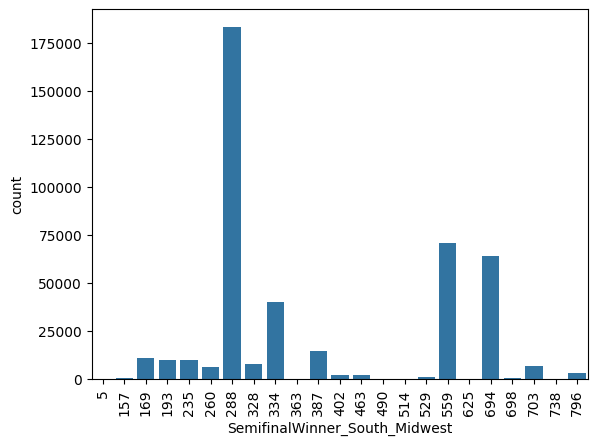

In [23]:
ax_1 = ax_1 = sns.countplot(x=model_1_df['SemifinalWinner_South_Midwest'])
plt.xticks(rotation=90)
plt.show()

In [24]:
college_info[college_info['InstitutionID'] == 288]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
14,288,Houston,Cougars,HOU,Houston,TX,77204,618,HOUSTON,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03


In [25]:
top_picks = college_info[(college_info["InstitutionID"] == 559) |
             (college_info["InstitutionID"] == 334) |
             (college_info["InstitutionID"] == 387) |
             (college_info["InstitutionID"] == 694) |
             (college_info['InstitutionID'] == 169) |
             (college_info["InstitutionID"] == 288)].sort_values('RegularSeasonWins', ascending=False)
top_picks.loc[:, ['InstitutionID', 'InstitutionName', 'InstitutionDMACode','RegularSeasonWins','RegularSeasonLosses','RegularSeasonAverageAttendance' ]]

,InstitutionID,InstitutionName,InstitutionDMACode,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance
14,288,Houston,618,30,4,9347.35
23,559,Purdue,582,29,4,13329.06
13,387,Marquette,617,25,9,14084.65
37,694,Tennessee,557,24,8,16065.47
9,334,Kentucky,541,23,9,17427.94
61,169,Creighton,652,23,9,13651.44


In [26]:
college_info[college_info["InstitutionID"] == 334]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
9,334,Kentucky,Wildcats,UK,Lexington,KY,40506,541,LEXINGTON,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44


In [27]:
college_info[college_info["InstitutionID"] == 387]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
13,387,Marquette,Golden Eagles,MARQ,Milwaukee,WI,53233,617,MILWAUKEE,43.03903,-87.92796,Big East Conference,3328,4200,7528,09/01/1928,25,9,14084.65,78.29


In [28]:
college_info[college_info["InstitutionID"] == 164]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
24,164,UConn,Huskies,UCONN,Storrs,CT,06269,533,HARTFORD & NEW HAVEN,41.8091,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47


In [ ]:
dma_count_groupby = classic1_df_train.groupby(by='CustomerDMACode').agg(semi_midwest_south_count= pd.NamedAgg(column='SemifinalWinner_South_Midwest', aggfunc='count'),
                                              semi_east_west_count= pd.NamedAgg(column='SemifinalWinner_East_West', aggfunc='count'))
dma_count_groupby

,semi_midwest_south_count,semi_east_west_count
CustomerDMACode,,
500.0,719,719
501.0,15432,15432
502.0,347,347
503.0,202,202
504.0,8417,8417
...,...,...
855.0,325,325
862.0,2230,2230
866.0,492,492


In [ ]:
dma_distribution_south_midwest = classic1_df_train.groupby(by =['CustomerDMACode', 'CustomerDMADescription'])['SemifinalWinner_South_Midwest'] \
                                             .value_counts() \
                                             .unstack(fill_value=0)
# dma_distribution_south_midwest.sort_values(559, ascending=False).head(20)

dma_distribution_south_midwest_prop = dma_distribution_south_midwest.div(dma_distribution_south_midwest.sum(axis=1), axis=0)

dma_distribution_south_midwest_prop.sort_values(772, ascending=False).head(10)
top_picks_by_dma = dma_distribution_south_midwest_prop.loc[:,[559, 334, 387, 694, 169, 288, 772]]
top_picks_by_dma['Sum'] = top_picks_by_dma[559] + top_picks_by_dma[334] + top_picks_by_dma[387] + top_picks_by_dma[694] + top_picks_by_dma[169] \
+ top_picks_by_dma[288]


top_picks_by_dma


,SemifinalWinner_South_Midwest,559,334,387,694,169,288,772,Sum
CustomerDMACode,CustomerDMADescription,,,,,,,,
500.0,PORTLAND - AUBURN,0.199219,0.164062,0.054688,0.085938,0.078125,0.246094,0.000000,0.828125
501.0,NEW YORK,0.162795,0.139371,0.059340,0.093305,0.083935,0.270935,0.000976,0.809682
502.0,BINGHAMTON,0.203704,0.185185,0.046296,0.120370,0.046296,0.166667,0.000000,0.768519
503.0,MACON,0.253968,0.142857,0.031746,0.095238,0.079365,0.158730,0.000000,0.761905
504.0,PHILADELPHIA,0.179601,0.131190,0.061345,0.101626,0.083518,0.268662,0.000000,0.825942
...,...,...,...,...,...,...,...,...,...
855.0,SANTABARBRA - SANMAR - SANLUOB,0.215054,0.075269,0.064516,0.053763,0.032258,0.311828,0.000000,0.752688
862.0,SACRAMNTO - STKTN - MODESTO,0.199721,0.113128,0.050279,0.082402,0.057263,0.293296,0.000000,0.796089
866.0,FRESNO - VISALIA,0.267974,0.111111,0.045752,0.058824,0.052288,0.287582,0.000000,0.823529


In [70]:
print(top_picks_by_dma.Sum.mean())

0.8123340775752241


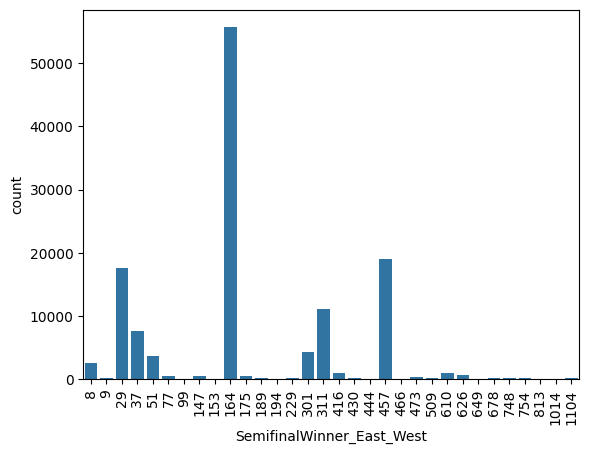

In [71]:
ax_1 = ax_1 = sns.countplot(x=model_1_df['SemifinalWinner_East_West'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
dma_distribution_east_west = classic1_df_train.groupby(by =['CustomerDMACode', 'CustomerDMADescription'])['SemifinalWinner_East_West'] \
                                             .value_counts() \
                                             .unstack(fill_value=0)

dma_distribution_east_west_prop = dma_distribution_east_west.div(dma_distribution_east_west.sum(axis=1), axis=0)


dma_ew = dma_distribution_east_west_prop.loc[:, [29,311,457,164]]
dma_ew['sum'] = dma_ew[29] + dma_ew[311] + dma_ew[457] + dma_ew[164]

dma_ew

,SemifinalWinner_East_West,29,311,457,164,sum
CustomerDMACode,CustomerDMADescription,,,,,
500.0,PORTLAND - AUBURN,0.113281,0.078125,0.167969,0.500000,0.859375
501.0,NEW YORK,0.118680,0.068124,0.148351,0.484287,0.819442
502.0,BINGHAMTON,0.212963,0.055556,0.138889,0.388889,0.796296
503.0,MACON,0.063492,0.047619,0.222222,0.412698,0.746032
504.0,PHILADELPHIA,0.133038,0.072062,0.168884,0.422395,0.796378
...,...,...,...,...,...,...
855.0,SANTABARBRA - SANMAR - SANLUOB,0.129032,0.075269,0.096774,0.537634,0.838710
862.0,SACRAMNTO - STKTN - MODESTO,0.146648,0.076816,0.148045,0.427374,0.798883
866.0,FRESNO - VISALIA,0.143791,0.111111,0.163399,0.431373,0.849673


In [73]:
dma_ew['sum'].mean()

np.float64(0.7965361293158172)

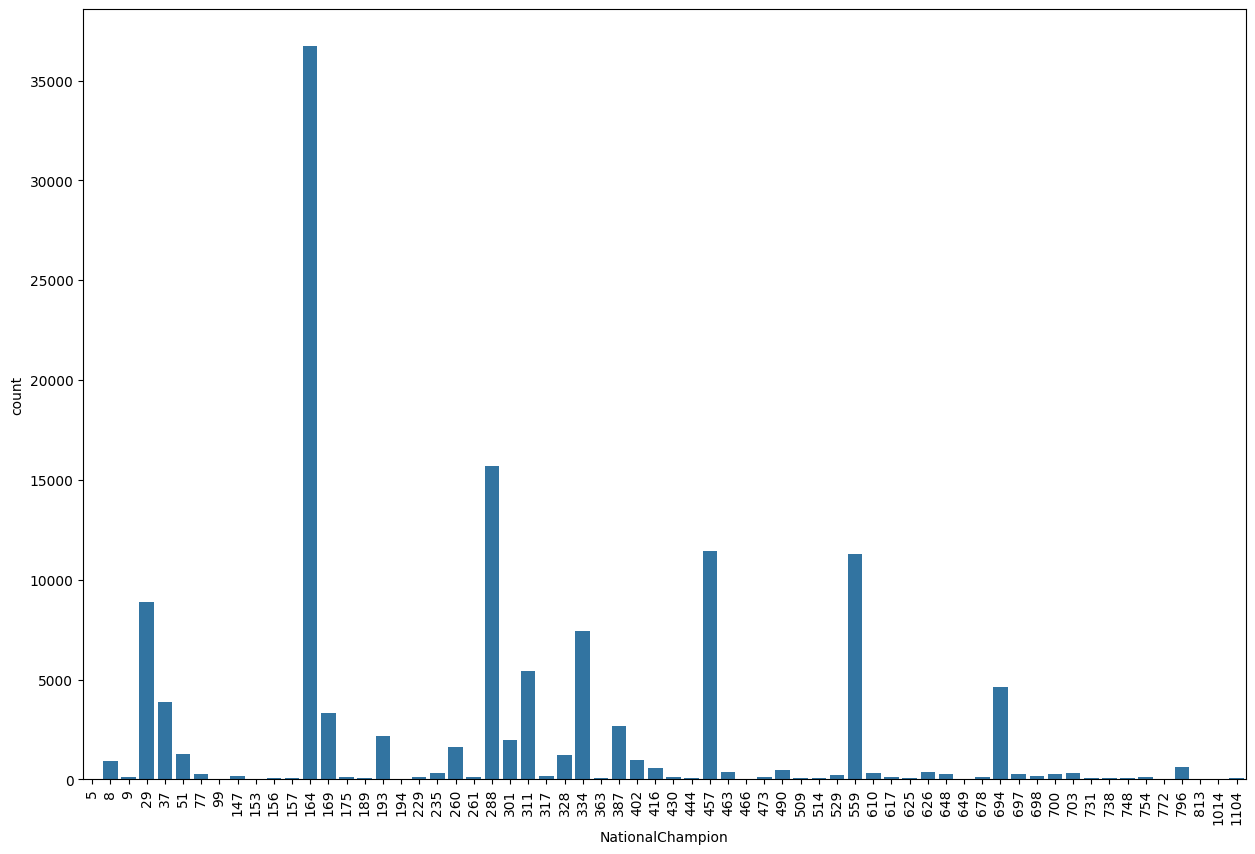

In [ ]:
plt.figure(figsize=(15,10))
ax_1 = ax_1 = sns.countplot(x=model_1_df['NationalChampion'])
plt.xticks(rotation=90)
plt.show()

In [37]:
#K-nearest neighbors

from sklearn.neighbors import NearestNeighbors
dma_count_midwest = classic1_df_train.groupby(by= ['CustomerDMACode', 'RegionWinner_Midwest']).size().reset_index(name='count')

# dma_count_midwest.loc[dma_count_midwest['CustomerDMACode'] == 500.0, :]
dma_count_midwest['Total_Picks'] = dma_count_midwest.groupby('CustomerDMACode')['count'].transform('sum')
dma_count_midwest['pick_prob'] = dma_count_midwest['count'] / dma_count_midwest['Total_Picks']


# Pivot table to transform region winners into separate columns
df_pivot = dma_count_midwest.pivot(index='CustomerDMACode', columns='RegionWinner_Midwest', values='pick_prob')

# Fill NaNs with 0 (since a DMA might not have chosen every team)
df_pivot = df_pivot.fillna(0)

# Reset index
df_pivot = df_pivot.reset_index()

df_pivot.columns = df_pivot.columns.astype(str)

classic1_df_train.loc[classic1_df_train['CustomerDMACode'] == 'Unknown', 'CustomerDMACode'] = 999


classic1_df_train['CustomerDMACode'] = classic1_df_train['CustomerDMACode'].astype(int)

df_pivot.sort_values('CustomerDMACode', ascending = True)

df_midwest_knn = df_pivot.merge(
    classic1_df_train[['CustomerDMACode', 'CustomerPostalCodeLongitude', 'CustomerPostalCodeLatitude']], 
    how='left', 
    on='CustomerDMACode'
)


X_train_knn_m, X_test_knn_m, y_train_knn_m,y_test_knn_m = train_test_split(df_midwest_knn.drop(columns=['CustomerDMACode']),df_midwest_knn['CustomerDMACode'], test_size=.2, random_state=24)

# Step 1: Extract only latitude & longitude for training
X_train_knn_m_geo = X_train_knn_m[['CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude']]

# Convert lat/lon to radians
X_train_knn_m_geo = np.radians(X_train_knn_m_geo)

# Step 2: Fit k-NN Model (Finding 5 Nearest DMAs)
knn = NearestNeighbors(n_neighbors=5, metric='haversine')
knn.fit(X_train_knn_m_geo)

X_test_knn_m_geo = X_test_knn_m[['CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude']]
X_test_knn_m_geo = np.radians(X_test_knn_m_geo)

# Step 4: Find Nearest Neighbors for New Customers
distances, indices = knn.kneighbors(X_test_knn_m_geo)

# Step 2: Retrieve the closest DMA picks from X_train
nearest_dmas = X_train_knn_m.iloc[indices.flatten()]

# Drop lat/lon before averaging (only keep team probabilities)
nearest_dmas = nearest_dmas.drop(columns=['CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude'])

# Step 5: Compute the average probabilities per customer from their k neighbors
estimated_probs = nearest_dmas.groupby(np.repeat(np.arange(len(X_test_knn_m)), knn.n_neighbors)).mean()

# Step 6: Rename columns with "M_" prefix
estimated_probs.columns = ['M_' + str(col) for col in estimated_probs.columns]
# # Step 3: Compute the average probabilities from k nearest DMAs
# estimated_probs = nearest_dmas.mean(axis=0)  # Take mean over k neighbors

# # Step 4: Merge estimated probabilities back into X_new

# X_test_knn_m.loc[:, estimated_probs.index] = estimated_probs.values

print(estimated_probs.shape)


# Step 2: Find the closest DMA for each row in `X_train_knn_m`
distances_train, indices_train = knn.kneighbors(X_train_knn_m_geo)

# Step 3: Retrieve regional probabilities from nearest neighbors
nearest_dmas_train = X_train_knn_m.iloc[indices_train.flatten()]

# Drop lat/lon columns (keep only team probabilities)
estimated_probs_train = nearest_dmas_train.drop(columns=['CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude'])

# Step 4: Rename columns with "M_" prefix
estimated_probs_train.columns = ['M_' + str(col) for col in estimated_probs_train.columns]

# Verify shape and output
print(estimated_probs_train.shape)  # Should be (104001, 17)
print(estimated_probs_train.head())

(26001, 16)
(520005, 16)
             M_5  M_156     M_169     M_260     M_261     M_328     M_402  \
129410  0.001272    0.0  0.193384  0.053435  0.006361  0.072519  0.022901   
129523  0.001272    0.0  0.193384  0.053435  0.006361  0.072519  0.022901   
129284  0.001272    0.0  0.193384  0.053435  0.006361  0.072519  0.022901   
129728  0.001272    0.0  0.193384  0.053435  0.006361  0.072519  0.022901   
129221  0.001272    0.0  0.193384  0.053435  0.006361  0.072519  0.022901   

           M_529     M_559     M_617     M_625     M_648     M_694    M_698  \
129410  0.015267  0.384224  0.005089  0.005089  0.016539  0.198473  0.01145   
129523  0.015267  0.384224  0.005089  0.005089  0.016539  0.198473  0.01145   
129284  0.015267  0.384224  0.005089  0.005089  0.016539  0.198473  0.01145   
129728  0.015267  0.384224  0.005089  0.005089  0.016539  0.198473  0.01145   
129221  0.015267  0.384224  0.005089  0.005089  0.016539  0.198473  0.01145   

          M_703     M_731  
129410  0

In [36]:
X_train_knn_m.shape[0]

104001

In [1]:
# %pip install pandas
# %pip install numpy
# %pip install seaborn
# %pip install scikit-learn
# %pip install tensorflow

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, make_scorer, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.linear_model import LassoCV, LogisticRegressionCV

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# 0. Load Data and Preprocessing (Existing Code)
# -------------------------------

path = os.getcwd()

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

bracket_training = pd.read_csv(f"{path}/bracket_training.csv", sep=",")
bracket_test = pd.read_csv(f'{path}/bracket_test.csv')
college_info = pd.read_csv(f'{path}/institutions.csv', sep=',', encoding='utf-8')
df_kenpom = pd.read_csv('Kenpom Data.csv')
distances_ew_df = pd.read_csv(f'{path}/SemifinalWinner_East_West.csv', sep='|')

# --- Step 1: Process KenPom Data
df_kenpom['Team_Name'] = df_kenpom['Team'].apply(lambda x: ' '.join(x.split()[:-1]))
mapping = {
    "Connecticut": "UConn", "Houston": "Houston", "Purdue": "Purdue", "Auburn": "Auburn",
    "Tennessee": "Tennessee", "Arizona": "Arizona", "Duke": "Duke", "Iowa St.": "Iowa St.",
    "North Carolina": "North Carolina", "Illinois": "Illinois", "Creighton": "Creighton",
    "Gonzaga": "Gonzaga", "Marquette": "Marquette", "Alabama": "Alabama", "Baylor": "Baylor",
    "Michigan St.": "Michigan St.", "Wisconsin": "Wisconsin", "BYU": "BYU", "Clemson": "Clemson",
    "Saint Mary's": "Saint Mary's", "San Diego St.": "San Diego St.", "Kentucky": "Kentucky",
    "Colorado": "Colorado", "Texas": "Texas", "Florida": "Florida", "Kansas": "Kansas",
    "New Mexico": "New Mexico", "Nebraska": "Nebraska", "Texas Tech": "Texas Tech",
    "Dayton": "Dayton", "Mississippi St.": "Mississippi St.", "Texas A&M": "Texas A&M",
    "Colorado St.": "Colorado St.", "Nevada": "Nevada", "Northwestern": "Northwestern",
    "Washington St.": "Washington St.", "TCU": "TCU", "Boise St.": "Boise St.",
    "N.C. State": "NC State", "Florida Atlantic": "FAU", "Utah St.": "Utah St.",
    "Grand Canyon": "Grand Canyon", "Drake": "Drake", "South Carolina": "South Carolina",
    "Oregon": "Oregon", "James Madison": "James Madison", "McNeese St.": "McNeese",
    "Virginia": "Virginia", "Samford": "Samford", "Duquesne": "Duquesne", "Yale": "Yale",
    "Charleston": "Charleston", "Vermont": "Vermont", "UAB": "UAB", "Morehead St.": "Morehead St.",
    "Akron": "Akron", "Oakland": "Oakland", "Western Kentucky": "Western Ky.",
    "South Dakota St.": "South Dakota St.", "Colgate": "Colgate", "Longwood": "Longwood",
    "Long Beach St.": "Long Beach St.", "Saint Peter's": "Saint Peter's", "Stetson": "Stetson",
    "Montana St.": "Montana St.", "Grambling St.": "Grambling St.", "Howard": "Howard", "Wagner": "Wagner"
}
df_kenpom['Team_Name'] = df_kenpom['Team_Name'].map(mapping)
df_kenpom['Seed_Rank'] = df_kenpom['Team'].str.extract(r'(\d+)$')
df_kenpom = df_kenpom.dropna(subset=['Seed_Rank'])
df_kenpom['Seed_Rank'] = df_kenpom['Seed_Rank'].astype(int)
df_ken_clean = df_kenpom.loc[:, ['Rk', 'Team_Name', 'Seed_Rank', 'NetRtg', 'Luck']]
df_ken_clean = df_ken_clean.set_index('Team_Name')

# --- Step 2: Merge with college_info and Join to Bracket Data
college_info_ken_df = college_info.join(df_ken_clean, how='left', on='InstitutionName')
college_info_ken_df['win_%'] = college_info_ken_df['RegularSeasonWins'] / (college_info_ken_df['RegularSeasonWins'] + college_info_ken_df['RegularSeasonLosses'])
college_info_ken_df = college_info_ken_df.set_index('InstitutionID')

train_df = bracket_training.join(
    college_info_ken_df.add_prefix("W_"), on="RegionWinner_West"
).join(
    college_info_ken_df.add_prefix("E_"), on="RegionWinner_East"
).join(
    college_info_ken_df.add_prefix('M_'), on="RegionWinner_Midwest"
).join(
    college_info_ken_df.add_prefix('S_'), on='RegionWinner_South'
)

test_df = bracket_test.join(
    college_info_ken_df.add_prefix("W_"), on="RegionWinner_West"
).join(
    college_info_ken_df.add_prefix("E_"), on="RegionWinner_East"
).join(
    college_info_ken_df.add_prefix('M_'), on="RegionWinner_Midwest"
).join(
    college_info_ken_df.add_prefix('S_'), on='RegionWinner_South'
)

classic1_df_train = train_df[[
    'CustomerID',
    'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude', 'CustomerDMACode', 'CustomerDMADescription',
    'NCAACustomerRecordCreated', 'BracketEntryId', 'BracketEntryCreatedDate',
    'RegionWinner_East', 'RegionWinner_West', 'RegionWinner_South', 'RegionWinner_Midwest',
    'SemifinalWinner_East_West', 'SemifinalWinner_South_Midwest', 'NationalChampion',
    'E_InstitutionName', 'E_InstitutionDMACode', 'E_InstitutionLatitude', 'E_InstitutionLongitude',
    'E_InstitutionConference', 'E_InstitutionEnrollment_Male', 'E_InstitutionEnrollment_Female',
    'E_InstitutionEnrollment_Total', 'E_InstitutionNCAAMemberSinceDate', 'E_RegularSeasonWins',
    'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance', 'E_RegularSeasonAverageScore',
    'E_Rk', 'E_Seed_Rank', 'E_NetRtg', 'E_Luck',
    'M_InstitutionName', 'M_InstitutionDMACode', 'M_InstitutionLatitude', 'M_InstitutionLongitude',
    'M_InstitutionConference', 'M_InstitutionEnrollment_Male', 'M_InstitutionEnrollment_Female',
    'M_InstitutionEnrollment_Total', 'M_InstitutionNCAAMemberSinceDate', 'M_RegularSeasonWins',
    'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance', 'M_RegularSeasonAverageScore',
    'M_Rk', 'M_Seed_Rank', 'M_NetRtg', 'M_Luck',
    'S_InstitutionName', 'S_InstitutionDMACode', 'S_InstitutionLatitude', 'S_InstitutionLongitude',
    'S_InstitutionConference', 'S_InstitutionEnrollment_Male', 'S_InstitutionEnrollment_Female',
    'S_InstitutionEnrollment_Total', 'S_InstitutionNCAAMemberSinceDate', 'S_RegularSeasonWins',
    'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance', 'S_RegularSeasonAverageScore',
    'S_Rk', 'S_Seed_Rank', 'S_NetRtg', 'S_Luck',
    'W_InstitutionName', 'W_InstitutionDMACode', 'W_InstitutionLatitude', 'W_InstitutionLongitude',
    'W_InstitutionConference', 'W_InstitutionEnrollment_Male', 'W_InstitutionEnrollment_Female',
    'W_InstitutionEnrollment_Total', 'W_InstitutionNCAAMemberSinceDate', 'W_RegularSeasonWins',
    'W_RegularSeasonLosses', 'W_RegularSeasonAverageAttendance', 'W_RegularSeasonAverageScore',
    'W_Rk', 'W_Seed_Rank', 'W_NetRtg', 'W_Luck'
]]
classic1_df_test = test_df[[
    'CustomerID',
    'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude', 'CustomerDMACode', 'CustomerDMADescription',
    'NCAACustomerRecordCreated', 'BracketEntryId', 'BracketEntryCreatedDate',
    'RegionWinner_East', 'RegionWinner_West', 'RegionWinner_South', 'RegionWinner_Midwest',
    'E_InstitutionName', 'E_InstitutionDMACode', 'E_InstitutionLatitude', 'E_InstitutionLongitude',
    'E_InstitutionConference', 'E_InstitutionEnrollment_Male', 'E_InstitutionEnrollment_Female',
    'E_InstitutionEnrollment_Total', 'E_InstitutionNCAAMemberSinceDate', 'E_RegularSeasonWins',
    'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance', 'E_RegularSeasonAverageScore',
    'E_Rk', 'E_Seed_Rank', 'E_NetRtg', 'E_Luck',
    'M_InstitutionName', 'M_InstitutionDMACode', 'M_InstitutionLatitude', 'M_InstitutionLongitude',
    'M_InstitutionConference', 'M_InstitutionEnrollment_Male', 'M_InstitutionEnrollment_Female',
    'M_InstitutionEnrollment_Total', 'M_InstitutionNCAAMemberSinceDate', 'M_RegularSeasonWins',
    'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance', 'M_RegularSeasonAverageScore',
    'M_Rk', 'M_Seed_Rank', 'M_NetRtg', 'M_Luck',
    'S_InstitutionName', 'S_InstitutionDMACode', 'S_InstitutionLatitude', 'S_InstitutionLongitude',
    'S_InstitutionConference', 'S_InstitutionEnrollment_Male', 'S_InstitutionEnrollment_Female',
    'S_InstitutionEnrollment_Total', 'S_InstitutionNCAAMemberSinceDate', 'S_RegularSeasonWins',
    'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance', 'S_RegularSeasonAverageScore',
    'S_Rk', 'S_Seed_Rank', 'S_NetRtg', 'S_Luck',
    'W_InstitutionName', 'W_InstitutionDMACode', 'W_InstitutionLatitude', 'W_InstitutionLongitude',
    'W_InstitutionConference', 'W_InstitutionEnrollment_Male', 'W_InstitutionEnrollment_Female',
    'W_InstitutionEnrollment_Total', 'W_InstitutionNCAAMemberSinceDate', 'W_RegularSeasonWins',
    'W_RegularSeasonLosses', 'W_RegularSeasonAverageAttendance', 'W_RegularSeasonAverageScore',
    'W_Rk', 'W_Seed_Rank', 'W_NetRtg', 'W_Luck'
]]
# Create separate imputers:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

# List the columns to impute:
num_cols = ['CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude']
cat_cols = ['CustomerDMACode', 'CustomerDMADescription']

# Impute in the training set:
classic1_df_train[num_cols] = num_imputer.fit_transform(classic1_df_train[num_cols])
classic1_df_train[cat_cols] = cat_imputer.fit_transform(classic1_df_train[cat_cols])

# And in the test set:
classic1_df_test[num_cols] = num_imputer.transform(classic1_df_test[num_cols])
classic1_df_test[cat_cols] = cat_imputer.transform(classic1_df_test[cat_cols])

# Create win percentages
classic1_df_train['m_win_%'] = classic1_df_train['M_RegularSeasonWins'] / (classic1_df_train['M_RegularSeasonWins'] + classic1_df_train['M_RegularSeasonLosses'])
classic1_df_train['s_win_%'] = classic1_df_train['S_RegularSeasonWins'] / (classic1_df_train['S_RegularSeasonWins'] + classic1_df_train['S_RegularSeasonLosses'])
classic1_df_train['e_win_%'] = classic1_df_train['E_RegularSeasonWins'] / (classic1_df_train['E_RegularSeasonWins'] + classic1_df_train['E_RegularSeasonLosses'])
classic1_df_train['w_win_%'] = classic1_df_train['W_RegularSeasonWins'] / (classic1_df_train['W_RegularSeasonWins'] + classic1_df_train['W_RegularSeasonLosses'])

classic1_df_test['m_win_%'] = classic1_df_test['M_RegularSeasonWins'] / (classic1_df_test['M_RegularSeasonWins'] + classic1_df_test['M_RegularSeasonLosses'])
classic1_df_test['s_win_%'] = classic1_df_test['S_RegularSeasonWins'] / (classic1_df_test['S_RegularSeasonWins'] + classic1_df_test['S_RegularSeasonLosses'])
classic1_df_test['e_win_%'] = classic1_df_test['E_RegularSeasonWins'] / (classic1_df_test['E_RegularSeasonWins'] + classic1_df_test['E_RegularSeasonLosses'])
classic1_df_test['w_win_%'] = classic1_df_test['W_RegularSeasonWins'] / (classic1_df_test['W_RegularSeasonWins'] + classic1_df_test['W_RegularSeasonLosses'])

# -------------------------------
# 3. Define Helper Functions for Modeling and Feature Engineering
# -------------------------------
# Custom sigmoid transformer (for ordinal features if needed)
def sigmoid_transform(X):
    try:
        return  1 - (1 / (1 + np.exp(-X)))
    except ZeroDivisionError:
        print('Bad Process!')
        
sigmoid_transformer = FunctionTransformer(sigmoid_transform, validate=False)

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c
def multioutput_accuracy(y_true, y_pred):
    # y_true and y_pred should be numpy arrays of shape (n_samples, n_outputs)
    accuracies = []
    for i in range(y_true.shape[1]):
        accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    return np.mean(accuracies)

custom_scorer = make_scorer(multioutput_accuracy)

# -------------------------------
# 4. Incorporate New Geographic & Popularity Features
# -------------------------------

epsilon = 1e-5
# %pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
df_train = classic1_df_train
df_test = classic1_df_test


# y = df_train['NationalChampion'] 
# df_train = df_train.drop(columns=['NationalChampion'])  # Features
#                 # Target

# smote_tomek = SMOTETomek(random_state=42)
# df_train, y = smote_tomek.fit_resample(df_train, y)

# df_train = pd.DataFrame(df_train, columns=df_train.columns)
# df_train['NationalChampion'] = y

#Apply haversine distance for each region winner column
for region, lat_data, lon_data in zip(
    ['E_','W_','M_', 'S_'],
    ['E_InstitutionLatitude', 'W_InstitutionLatitude', 'M_InstitutionLatitude', 'S_InstitutionLatitude'],
    ['E_InstitutionLongitude', 'W_InstitutionLongitude', 'M_InstitutionLongitude', 'S_InstitutionLongitude']
):
    df_train[f'{region}distance'] =  df_train.apply(
        lambda row: haversine_distance(row['CustomerPostalCodeLatitude'],
                                       row['CustomerPostalCodeLongitude'],
                                       row[lat_data],
                                       row[lon_data])
    , axis = 1)
    df_test[f'{region}distance'] =  df_test.apply(
        lambda row: haversine_distance(row['CustomerPostalCodeLatitude'],
                                       row['CustomerPostalCodeLongitude'],
                                       row[lat_data],
                                       row[lon_data])
    , axis = 1)

for region in ['E_', 'W_', 'M_', 'S_']:
    df_train[f'{region}dist_score'] = 1 / (df_train[f'{region}distance'] + epsilon)
    df_train = df_train.drop(columns=[f'{region}distance'])

    df_test[f'{region}dist_score'] = 1 / (df_test[f'{region}distance'] + epsilon)
    df_test = df_test.drop(columns=[f'{region}distance'])

# Sum of East & West distance scores
df_train['total_dist_score_EW'] = df_train[['E_dist_score', 'W_dist_score']].sum(axis=1)

# Sum of Midwest & South distance scores
df_train['total_dist_score_MS'] = df_train[['M_dist_score', 'S_dist_score']].sum(axis=1)

# Normalize East & West probabilities
df_train['E_dist_prob'] = df_train['E_dist_score'] / df_train['total_dist_score_EW']
df_train['W_dist_prob'] = df_train['W_dist_score'] / df_train['total_dist_score_EW']

# Normalize Midwest & South probabilities
df_train['M_dist_prob'] = df_train['M_dist_score'] / df_train['total_dist_score_MS']
df_train['S_dist_prob'] = df_train['S_dist_score'] / df_train['total_dist_score_MS']

df_train = df_train.drop(columns=[
    'E_dist_score', 'W_dist_score', 'M_dist_score', 'S_dist_score',
    'total_dist_score_EW', 'total_dist_score_MS'
])


# Sum of East & West distance scores
df_test['total_dist_score_EW'] = df_test[['E_dist_score', 'W_dist_score']].sum(axis=1)

# Sum of Midwest & South distance scores
df_test['total_dist_score_MS'] = df_test[['M_dist_score', 'S_dist_score']].sum(axis=1)

# Normalize East & West probabilities
df_test['E_dist_prob'] = df_test['E_dist_score'] / df_test['total_dist_score_EW']
df_test['W_dist_prob'] = df_test['W_dist_score'] / df_test['total_dist_score_EW']

# Normalize Midwest & South probabilities
df_test['M_dist_prob'] = df_test['M_dist_score'] / df_test['total_dist_score_MS']
df_test['S_dist_prob'] = df_test['S_dist_score'] / df_test['total_dist_score_MS']


df_test = df_test.drop(columns=[
    'E_dist_score', 'W_dist_score', 'M_dist_score', 'S_dist_score',
    'total_dist_score_EW', 'total_dist_score_MS'
])

# -------------------------------
# 5. Define Feature Columns and Multi-Output Targets for Joint Modeling
# -------------------------------

# Drop withheld features
features_to_withHold = ['CustomerID',
                         'CustomerPostalCodeLatitude', 
                         'CustomerPostalCodeLongitude',
                         'CustomerDMACode',
                         'CustomerDMADescription',
                        'NCAACustomerRecordCreated',
                        'BracketEntryId',
                        'BracketEntryCreatedDate',
    'E_InstitutionName', 'E_InstitutionDMACode', 'E_InstitutionLatitude', 'E_InstitutionLongitude','E_RegularSeasonWins', 'E_RegularSeasonLosses',
    'E_InstitutionNCAAMemberSinceDate', 'E_InstitutionEnrollment_Female','E_InstitutionEnrollment_Male','E_RegularSeasonAverageAttendance', "E_RegularSeasonAverageScore",
    'E_InstitutionConference',

    'W_InstitutionName', 'W_InstitutionDMACode', 'W_InstitutionLatitude', 'W_InstitutionLongitude','W_RegularSeasonWins', 'W_RegularSeasonLosses',
    'W_InstitutionEnrollment_Male', 'W_InstitutionEnrollment_Female', 'W_InstitutionNCAAMemberSinceDate', 'W_InstitutionEnrollment_Male',
    'W_RegularSeasonAverageAttendance', "W_RegularSeasonAverageScore", 'W_InstitutionConference',

    'M_InstitutionName',
 'M_InstitutionDMACode',
 'M_InstitutionLatitude',
 'M_InstitutionLongitude',
 'M_RegularSeasonWins', 'M_RegularSeasonLosses',
 'M_InstitutionNCAAMemberSinceDate',
 'M_InstitutionEnrollment_Female', 'M_InstitutionEnrollment_Male',
 'M_RegularSeasonAverageAttendance', "M_RegularSeasonAverageScore",
 'M_InstitutionConference',


 'S_InstitutionName',
 'S_InstitutionDMACode',
 'S_InstitutionLatitude',
 'S_InstitutionLongitude',
 'S_RegularSeasonWins', 'S_RegularSeasonLosses',
 'S_InstitutionEnrollment_Male',
 'S_InstitutionEnrollment_Female', 'S_InstitutionEnrollment_Male',
 'S_RegularSeasonAverageAttendance', "S_RegularSeasonAverageScore",
 'S_InstitutionNCAAMemberSinceDate',
 'S_InstitutionConference'
]

df_train = df_train.drop(columns=features_to_withHold)
df_test = df_test.drop(columns=features_to_withHold)


# Create lists of features based on column name prefixes.
features_east = [col for col in df_train.columns if col.startswith('E_') | col.startswith('e_')]
features_west = [col for col in df_train.columns if col.startswith('W_') | col.startswith('w_')]
features_midwest = [col for col in df_train.columns if col.startswith('M_') | col.startswith('m_')]
features_south = [col for col in df_train.columns if col.startswith('S_') | col.startswith('s_')]


# Define target column names.
from sklearn.feature_selection import RFE


target_EW = "SemifinalWinner_East_West"    # outcome for East-West semifinal
target_MS = "SemifinalWinner_South_Midwest"  # outcome for South-Midwest semifinal
target_NC = "NationalChampion"             # outcome for National Champion

df_train['target_EW_Binary'] = (df_train[target_EW] == df_train['RegionWinner_East']).astype(int)
# df_test['target_EW_Binary'] = (df_test[target_EW] == df_test['RegionWinner_East']).astype(int)

df_train['target_MS_Binary'] = (df_train[target_MS] == df_train['RegionWinner_Midwest']).astype(int)
# df_test['target_MS_Binary'] = (df_test[target_MS] == df_test['RegionWinner_Midwest']).astype(int)


# Remove target columns from the feature lists if present.
for target in [target_EW, target_MS, target_NC, 'target_EW_Binary', 'target_MS_Binary']:
    if target in features_east: features_east.remove(target)
    if target in features_west: features_west.remove(target)
    if target in features_midwest: features_midwest.remove(target)
    if target in features_south: features_south.remove(target)

# Combine feature lists.
features_ew = features_east + features_west
features_ms = features_south + features_midwest

# # # -------------------------------
# # # 6. Build a Shared Preprocessing Pipeline
# # # -------------------------------

ordinal_features_ew = [col for col in features_ew if col.endswith("_Rk") |  col.endswith('_Seed_Rank')]
numerical_features_ew = [col for col in features_ew if col not in ordinal_features_ew 
                      and col not in ['E_dist_prob', 'W_dist_prob']
                      and col not in ['RegionWinner_East','RegionWinner_South', 'RegionWinner_Midwest', 'RegionWinner_West']
                      and col not in ['target_EW_Binary', 'target_MS_Binary']]


ordinal_features_ms = [col for col in features_ms if col.endswith("_Rk") |  col.endswith('_Seed_Rank')]
numerical_features_ms = [col for col in features_ms if col not in ordinal_features_ms 
                      and col not in [ 'S_dist_prob', 'M_dist_prob']
                      and col not in ['RegionWinner_East','RegionWinner_South', 'RegionWinner_Midwest', 'RegionWinner_West']
                      and col not in ['target_EW_Binary', 'target_MS_Binary']]



y_ew = df_train['target_EW_Binary']
y_ms = df_train['target_MS_Binary']

y_ms

df_train = df_train.drop(columns= ['target_EW_Binary','target_MS_Binary' ])


X_train_ew, X_test_ew, y_train_ew, y_test_ew = train_test_split(df_train[features_ew], y_ew, test_size=.2, random_state=24)
X_train_ms, X_test_ms, y_train_ms, y_test_ms = train_test_split(df_train[features_ms], y_ms,  test_size=.2, random_state=24)

preprocessor_log_ew = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_ew),
        ('ord', sigmoid_transformer, ordinal_features_ew)
    ],
    remainder='passthrough'
)

preprocessor_log_ms = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_ms),
        ('ord', sigmoid_transformer, ordinal_features_ms)
    ],
    remainder='passthrough'
)



df_train[features_ew]
processed_data = pd.DataFrame(preprocessor_log_ew.fit_transform(df_train[features_ew]))
processed_data
# -------------------------------
# 7. Build the Joint Multi-Task Model
# -------------------------------
model_log_reg_ew = Pipeline(steps=[
    ('preprocessor', preprocessor_log_ew),
    ('selector', RFE(LogisticRegressionCV(cv=5, max_iter=2000), n_features_to_select=10)),
    ('classifier', LogisticRegressionCV(cv=5, max_iter=2000))
])

model_log_reg_ms = Pipeline(steps=[
    ('preprocessor', preprocessor_log_ms),
    ('selector', RFE(LogisticRegressionCV(cv=5, max_iter=2000), n_features_to_select=10)),
    ('classifier', LogisticRegressionCV(cv=5, max_iter=2000))
])


classic1_df_train

,CustomerID,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,CustomerDMADescription,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,E_InstitutionName,E_InstitutionDMACode,E_InstitutionLatitude,E_InstitutionLongitude,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Female,E_InstitutionEnrollment_Total,E_InstitutionNCAAMemberSinceDate,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,E_Rk,E_Seed_Rank,E_NetRtg,E_Luck,M_InstitutionName,M_InstitutionDMACode,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,M_Rk,M_Seed_Rank,M_NetRtg,M_Luck,S_InstitutionName,S_InstitutionDMACode,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,S_Rk,S_Seed_Rank,S_NetRtg,S_Luck,W_InstitutionName,W_InstitutionDMACode,W_InstitutionLatitude,W_InstitutionLongitude,W_InstitutionConference,W_InstitutionEnrollment_Male,W_InstitutionEnrollment_Female,W_InstitutionEnrollment_Total,W_InstitutionNCAAMemberSinceDate,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore,W_Rk,W_Seed_Rank,W_NetRtg,W_Luck,m_win_%,s_win_%,e_win_%,w_win_%,E_distance,W_distance,M_distance,S_distance,E_dist_score
0,47028,32.5622,-86.0994,698.0,MONTGOMERY (SELMA),2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,1,1,36.43,0.037,Tennessee,557,35.95208,-83.92585,Southeastern Conference,15269,18536,33805,09/01/1909,24,8,16065.47,79.47,5,2,26.61,-0.026,James Madison,569,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35,63,12,12.42,0.093,Arizona,789,32.23267,-110.95080,Pac-12 Conference,13090,17292,30382,09/01/1936,25,8,12118.18,87.94,6,2,26.55,-0.047,0.750000,0.911765,0.911765,0.757576,1597.133829,2328.202760,426.563483,923.981672,0.000626
1,3511,42.8256,-86.0104,563.0,GRAND RAPIDS - KALMZOO - B. CRK,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,1,1,36.43,0.037,Kansas,616,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,27,4,17.94,0.058,Kentucky,541,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,23,3,19.29,-0.040,Baylor,625,31.54687,-97.12104,Big 12 Conference,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,15,3,21.90,-0.016,0.687500,0.718750,0.911765,0.696970,1135.742592,1591.208951,886.829991,547.271060,0.000880
2,58445,38.8808,-77.1129,511.0,"WASHINGTON, DC (HAGRSTWN)",2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,1,1,36.43,0.037,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,3,1,30.62,0.048,Houston,618,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03,2,1,31.17,0.042,Baylor,625,31.54687,-97.12104,Big 12 Conference,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,15,3,21.90,-0.016,0.878788,0.882353,0.911765,0.696970,525.083169,1986.571818,856.081303,1954.472608,0.001904
3,28833,29.4969,-98.4032,641.0,SAN ANTONIO,2023-11-16,3384825,2024-03-21 1

In [2]:
model_log_reg_ew.fit(X_train_ew, y_train_ew)
y_pred_ew = model_log_reg_ew.predict(X_test_ew)
print( f'Accuracy for EW Model: {accuracy_score(y_true=y_test_ew, y_pred=y_pred_ew)}')
model_log_reg_ms.fit(X_train_ms, y_train_ms)
y_pred_ms = model_log_reg_ms.predict(X_test_ms)
print( f'Accuracy for MS Model: {accuracy_score(y_true=y_test_ms, y_pred=y_pred_ms)}')



Accuracy for EW Model: 0.6748971193415638
Accuracy for MS Model: 0.6282835275566324


In [2]:
X_train_ew

,E_InstitutionEnrollment_Total,E_Rk,E_Seed_Rank,E_NetRtg,E_Luck,e_win_%,E_dist_prob,W_InstitutionEnrollment_Total,W_Rk,W_Seed_Rank,W_NetRtg,W_Luck,w_win_%,W_dist_prob
129410,22479,1,1,36.43,0.037,0.911765,0.635322,30382,6,2,26.55,-0.047,0.757576,0.364678
26132,25379,4,4,27.99,-0.080,0.794118,0.722477,14885,15,3,21.90,-0.016,0.696970,0.277523
127143,22479,1,1,36.43,0.037,0.911765,0.439085,30382,6,2,26.55,-0.047,0.757576,0.560915
23392,22479,1,1,36.43,0.037,0.911765,0.463560,30382,6,2,26.55,-0.047,0.757576,0.536440
12944,22479,1,1,36.43,0.037,0.911765,0.427085,20242,9,1,26.19,-0.038,0.794118,0.572915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85393,22479,1,1,36.43,0.037,0.911765,0.910594,30382,6,2,26.55,-0.047,0.757576,0.089406
123223,25241,8,2,26.47,0.002,0.794118,0.599248,30382,6,2,26.55,-0.047,0.757576,0.400752
80064,22479,1,1,36.43,0.037,0.911765,0.673625,30382,6,2,26.55,-0.047,0.757576,0.326375
899,25379,4,4,27.99,-0.080,0.794118,0.631156,30382,6,2,26.55,-0.047,0.757576,0.368844


In [35]:
model_log_reg_ms.fit(X_train_ms, y_train_ms)
y_pred_ms = model_log_reg_ms.predict(X_test_ms)
print( f'Accuracy for MS Model: {accuracy_score(y_true=y_test_ms, y_pred=y_pred_ms)}')

Accuracy for MS Model: 0.6282835275566324


In [61]:
from tensorflow.keras.utils import to_categorical

def final_four_encoder(row):
    if row['NationalChampion'] == row['RegionWinner_East']:
        return 0
    elif row['NationalChampion'] == row['RegionWinner_West']:
        return 1
    elif row['NationalChampion'] == row['RegionWinner_Midwest']:
        return 2
    else: 
        return 3
    
    # row['NationalChampion'] == row['RegionWinner_South']:
    # else:
    #     return np.nan  # Handle unexpected cases

df_train['National_Champ_Label'] = df_train.apply(final_four_encoder, axis = 1)

df_train

,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,E_InstitutionEnrollment_Total,E_Rk,E_Seed_Rank,E_NetRtg,E_Luck,M_InstitutionEnrollment_Total,M_Rk,M_Seed_Rank,M_NetRtg,M_Luck,S_InstitutionEnrollment_Total,S_Rk,S_Seed_Rank,S_NetRtg,S_Luck,W_InstitutionEnrollment_Total,W_Rk,W_Seed_Rank,W_NetRtg,W_Luck,m_win_%,s_win_%,e_win_%,w_win_%,E_dist_prob,W_dist_prob,M_dist_prob,S_dist_prob,National_Champ_Label
0,164,29,317,694,164,694,694,22479,1,1,36.43,0.037,33805,5,2,26.61,-0.026,20346,63,12,12.42,0.093,30382,6,2,26.55,-0.047,0.750000,0.911765,0.911765,0.757576,0.593122,0.406878,0.684155,0.315845,2
1,164,51,334,328,164,334,164,22479,1,1,36.43,0.037,18704,27,4,17.94,0.058,22723,23,3,19.29,-0.040,14885,15,3,21.90,-0.016,0.687500,0.718750,0.911765,0.696970,0.583512,0.416488,0.381613,0.618387,0
2,164,51,288,559,164,559,559,22479,1,1,36.43,0.037,37949,3,1,30.62,0.048,37943,2,1,31.17,0.042,14885,15,3,21.90,-0.016,0.878788,0.882353,0.911765,0.696970,0.790941,0.209059,0.695405,0.304595,2
3,311,610,490,559,311,490,490,25241,8,2,26.47,0.002,37949,3,1,30.62,0.048,23443,45,11,15.90,0.014,1949,20,5,19.43,0.008,0.878788,0.611111,0.794118,0.787879,0.619592,0.380408,0.551714,0.448286,3
4,37,457,387,169,457,387,457,25379,4,4,27.99,-0.080,4290,11,3,24.22,-0.018,7528,13,2,23.02,0.035,20242,9,1,26.19,-0.038,0.718750,0.735294,0.794118,0.794118,0.376739,0.623261,0.342400,0.657600,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129997,311,457,334,694,311,694,311,25241,8,2,26.47,0.002,33805,5,2,26.61,-0.026,22723,23,3,19.29,-0.040,20242,9,1,26.19,-0.038,0.750000,0.718750,0.794118,0.794118,0.699813,0.300187,0.484898,0.515102,0
129998,311,8,288,694,8,288,288,25241,8,2,26.47,0.002,33805,5,2,26.61,-0.026,37943,2,1,31.17,0.042,32458,14,4,22.96,-0.001,0.750000,0.882353,0.794118,0.656250,0.385504,0.614496,0.028028,0.971972,3
129999,164,457,288,169,164,288,164,22479,1,1,36.43,0.037,4290,11,3,24.22,-0.018,37943,2,1,31.17,0.042,20242,9,1,26.19,-0.038,0.718750,0.882353,0.911765,0.794118,0.474127,0.525873,0.550592,0.449408,0
130000,164,8,334,559,164,559,559,22479,1,1,36.43,0.037,37949,3,1,30.62,0.048,22723,23,3,19.29,-0.040,32458,14,4,22.96,-0.001,0.878788,0.718750,0.911765,0.656250,0.041533,0.958467,0.416476,0.583524,2


In [62]:
y_final = to_categorical(df_train['National_Champ_Label'], 4)




In [3]:

# %pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

final_features = features_ew + features_ms


y_nc = y
# y_nc = df_train['NationalChampion']
# y_nc.nunique()


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(df_train[final_features], y_nc, stratify=  y_nc, test_size=0.2, random_state=42)




# preprocessor_nc = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features_ew + numerical_features_ms ),
#         ('ord', sigmoid_transformer, ordinal_features_ew + ordinal_features_ms)
#     ],
#     remainder='passthrough'
# )



model_xgb = Pipeline(steps=[
    ('selector', RFE(LogisticRegressionCV(cv=5, max_iter=2000), n_features_to_select=10)),
    ('classifier', XGBClassifier(objective='multi:softmax', num_class=64, eval_metric='mlogloss', use_label_encoder=False))
],
)

cv_scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='accuracy')

# model_log_reg_nc = Pipeline(steps=[
#     ('preprocessor', preprocessor_nc),
#     ('selector', RFE(LogisticRegressionCV(cv=5, max_iter=2000), n_features_to_select=10)),
#     ('classifier', LogisticRegressionCV(cv=5, max_iter=2000, multi_class='multinomial', solver='lbfgs'))
# ])

# model_log_reg_nc.fit(X_train, y_train)
# y_pred = model_log_reg_nc.predict(X_test)
# print( f'Accuracy for MS Model: {accuracy_score(y_true=y_test, y_pred=y_pred)}')

NameError: name 'y' is not defined

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# df_train

df_test['Pred_SemifinalWinner_East_West'] = predictions_df['SemifinalWinner_East_West']
df_test['Pred_SemifinalWinner_South_Midwest'] = predictions_df['SemifinalWinner_South_Midwest']



# Define mappings for the EW group: (suffix, true_prefix, false_prefix)
ew_cols = [
    ("InstitutionEnrollment_Total", "E_", "W_"),
    ("Rk", "E_", "W_"),
    ("Seed_Rank", "E_", "W_"),
    ("NetRtg", "E_", "W_"),
    ("Luck", "E_", "W_"),
    ("win_%", "e_", "w_"),
    ('dist_prob', 'E_','W_')
]

# Define mappings for the MS group: (suffix, true_prefix, false_prefix)
ms_cols = [
     ("InstitutionEnrollment_Total", "M_", "S_"),
    ("Rk", "M_", "S_"),
    ("Seed_Rank", "M_", "S_"),
    ("NetRtg", "M_", "S_"),
    ("Luck", "M_", "S_"),
    ("win_%", "m_", "s_"),
    ('dist_prob', 'M_','S_')
]
drop_list = []

print(df_train.columns)
# Create EW columns in the training dataset
for suffix, true_prefix, false_prefix in ew_cols:
    new_col = "EW_" + suffix
    df_train[new_col] = df_train[true_prefix + suffix].where(
        df_train["SemifinalWinner_East_West"] == df_train["RegionWinner_East"],
        df_train[false_prefix + suffix]
    )
    if f'true_prefix + suffix'.startswith('E_'):
        drop_list.append(f'{false_prefix + suffix}')
    else:
        drop_list.append(f'{true_prefix + suffix}')


# Create MS columns in the training dataset
for suffix, true_prefix, false_prefix in ms_cols:
    new_col = "MS_" + suffix
    df_train[new_col] = df_train[true_prefix + suffix].where(
        df_train["SemifinalWinner_South_Midwest"] == df_train["RegionWinner_Midwest"],
        df_train[false_prefix + suffix]
    )
    if f'true_prefix + suffix'.startswith('M_'):
        drop_list.append(f'{false_prefix + suffix}')
    else:
        drop_list.append(f'{true_prefix + suffix}')

# For the test dataset
# Assume df_test is already loaded and classic1_df_test is available for source values.
nat_champ_df_test = df_test

# Create EW columns in the test dataset
for suffix, true_prefix, false_prefix in ew_cols:
    new_col = "EW_" + suffix
    df_test[new_col] = df_test[true_prefix + suffix].where(
        df_test["Pred_SemifinalWinner_East_West"] == df_test["RegionWinner_East"],
        df_test[false_prefix + suffix]
    )

# Create MS columns in the test dataset
for suffix, true_prefix, false_prefix in ms_cols:
    new_col = "MS_" + suffix
    df_test[new_col] = df_test[true_prefix + suffix].where(
        df_test["Pred_SemifinalWinner_South_Midwest"] == df_test["RegionWinner_Midwest"],
        df_test[false_prefix + suffix]
    )

df_train_xgb = df_train.drop(columns=[col for col in df_train.columns if not (col.startswith('EW_') or col.startswith('MS_'))])
df_test_xgb = df_test.drop(columns=[col for col in df_test.columns if not (col.startswith('EW_') or col.startswith('MS_'))])

from imblearn.combine import SMOTETomek



smote_tomek = SMOTETomek(random_state=42)

y_xgb = df_train['NationalChampion']
df_train_xgb, y = smote_tomek.fit_resample(df_train_xgb, y_xgb)


df_train_xgb = pd.DataFrame(df_train_xgb, columns=df_train_xgb.columns)
df_train_xgb['NationalChampion'] = y


# 🎯 1️⃣ Create Binary Target Variable
y_xgb = (df_train['NationalChampion'] == df_train['SemifinalWinner_East_West']).astype(int)

# 🎯 2️⃣ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(df_train_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb)

# 🎯 3️⃣ Define XGBoost Model
xgb_clf = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',        # Log loss for binary problems
    use_label_encoder=False,
    max_depth=3,
    n_estimators=50,
    subsample=0.8,
    colsample_bytree=0.8
)

# 🎯 4️⃣ Set Up Cross-Validation (5-Fold Stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=cv, scoring='accuracy')

# 🎯 5️⃣ Print Cross-Validation Results
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(confusion_matrix())

# # 🎯 6️⃣ Train Final Model on Full Training Data
# xgb_clf.fit(X_train, y_train)

# # 🎯 7️⃣ Predict on Test Set
# y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]  # Get probabilities for class 1 (EW wins)
# y_pred_binary = (y_pred_proba >= 0.5).astype(int)   # Convert to binary predictions

# # 🎯 8️⃣ Store Predictions in df_test
# df_test['Predicted_Champion_Group'] = y_pred_binary  # 1 = EW wins, 0 = MW/S wins

# # Print a few prediction results
# print(df_test[['Predicted_Champion_Group']].head())


# y_xgb = (df_train['NationalChampion'] == df_train['SemifinalWinner_East_West']).astype(int)

# # Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(df_train_xgb, y_xgb, test_size=0.2, random_state=42)

# # Encode labels so they start from 0
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)

# # Train XGB Model
# xgb_clf = XGBClassifier(
#     objective='multi:softmax',
#     num_class=len(label_encoder.classes_),  # Ensure num_class matches the actual number of labels
#     eval_metric='mlogloss',
#     use_label_encoder=False,
#     max_depth=3,
#     n_estimators=50,
#     subsample=0.8,
#     colsample_bytree=0.8
# )
# xgb_clf.fit(X_train, y_train_encoded)

# # Predict and convert predictions back to original team IDs
# y_pred = xgb_clf.predict(X_test)
# y_pred_original = label_encoder.inverse_transform(y_pred).where(df_test['NationalChampion'] == df_train['SemifinalWinner_East_West'])  # Converts back to original labels
# # Print Accuracy
# from sklearn.metrics import accuracy_score
# print("Test Accuracy:", accuracy_score(y_test_encoded, y_pred))


Index(['RegionWinner_East', 'RegionWinner_West', 'RegionWinner_South',
       'RegionWinner_Midwest', 'SemifinalWinner_East_West',
       'SemifinalWinner_South_Midwest', 'NationalChampion',
       'E_InstitutionEnrollment_Total', 'E_Rk', 'E_Seed_Rank', 'E_NetRtg',
       'E_Luck', 'M_InstitutionEnrollment_Total', 'M_Rk', 'M_Seed_Rank',
       'M_NetRtg', 'M_Luck', 'S_InstitutionEnrollment_Total', 'S_Rk',
       'S_Seed_Rank', 'S_NetRtg', 'S_Luck', 'W_InstitutionEnrollment_Total',
       'W_Rk', 'W_Seed_Rank', 'W_NetRtg', 'W_Luck', 'm_win_%', 's_win_%',
       'e_win_%', 'w_win_%', 'E_dist_prob', 'W_dist_prob', 'M_dist_prob',
       'S_dist_prob'],
      dtype='object')


ValueError: Found input variables with inconsistent numbers of samples: [2327396, 130002]

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import pandas as pd



from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# df_train

df_test['Pred_SemifinalWinner_East_West'] = predictions_df['SemifinalWinner_East_West']
df_test['Pred_SemifinalWinner_South_Midwest'] = predictions_df['SemifinalWinner_South_Midwest']



# Define mappings for the EW group: (suffix, true_prefix, false_prefix)
ew_cols = [
    ("InstitutionEnrollment_Total", "E_", "W_"),
    ("Rk", "E_", "W_"),
    ("Seed_Rank", "E_", "W_"),
    ("NetRtg", "E_", "W_"),
    ("Luck", "E_", "W_"),
    ("win_%", "e_", "w_"),
    ('dist_prob', 'E_','W_')
]

# Define mappings for the MS group: (suffix, true_prefix, false_prefix)
ms_cols = [
     ("InstitutionEnrollment_Total", "M_", "S_"),
    ("Rk", "M_", "S_"),
    ("Seed_Rank", "M_", "S_"),
    ("NetRtg", "M_", "S_"),
    ("Luck", "M_", "S_"),
    ("win_%", "m_", "s_"),
    ('dist_prob', 'M_','S_')
]

# ---- Create new feature columns ----
drop_list = []

# Create EW columns in the training dataset
for suffix, true_prefix, false_prefix in ew_cols:
    new_col = "EW_" + suffix
    df_train[new_col] = df_train[true_prefix + suffix].where(
        df_train["SemifinalWinner_East_West"] == df_train["RegionWinner_East"],
        df_train[false_prefix + suffix]
    )
    if true_prefix.startswith('E_'):  # ✅ Corrected condition
        drop_list.append(false_prefix + suffix)
    else:
        drop_list.append(true_prefix + suffix)

# Create MS columns in the training dataset
for suffix, true_prefix, false_prefix in ms_cols:
    new_col = "MS_" + suffix
    df_train[new_col] = df_train[true_prefix + suffix].where(
        df_train["SemifinalWinner_South_Midwest"] == df_train["RegionWinner_Midwest"],
        df_train[false_prefix + suffix]
    )
    if true_prefix.startswith('M_'):  # ✅ Corrected condition
        drop_list.append(false_prefix + suffix)
    else:
        drop_list.append(true_prefix + suffix)

# ---- Feature Selection ----
df_train_xgb = df_train.drop(columns=[col for col in df_train.columns if not (col.startswith('EW_') or col.startswith('MS_'))])
df_test_xgb = df_test.drop(columns=[col for col in df_test.columns if not (col.startswith('EW_') or col.startswith('MS_'))])


# ---- Apply SMOTETomek Resampling ----
smote_ = SMOTE(random_state=42)

# Extract Features & Target
y_xgb = df_train['NationalChampion']
df_train_xgb = df_train.drop(columns=['NationalChampion'])

# Apply SMOTETomek
df_train_xgb, y_resampled = smote_.fit_resample(df_train_xgb, y_xgb)

# Convert back to DataFrame
df_train_xgb = pd.DataFrame(df_train_xgb, columns=df_train_xgb.columns)
df_train_xgb['NationalChampion'] = y_resampled  # ✅ Correct resampled labels

df_train_xgb

# # ---- Train/Test Split ----
# X_train, X_test, y_train, y_test = train_test_split(
#     df_train_xgb.drop(columns=['NationalChampion']),
#     df_train_xgb['NationalChampion'],
#     test_size=0.2,
#     random_state=42,
#     stratify=df_train_xgb['NationalChampion']
# )

# # ---- Encode Labels Properly ----
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)  # Convert to [0, 1, ..., num_classes-1]
# y_test_encoded = label_encoder.transform(y_test)  # Apply same encoding to test labels

# # ---- Define XGBoost Model for Multi-Class ----
# xgb_clf = XGBClassifier(
#     objective='multi:softmax',  # Multi-class classification
#     num_class=len(label_encoder.classes_),  # Number of unique classes
#     eval_metric='mlogloss',
#     max_depth=3,
#     n_estimators=3,
#     subsample=0.8,
#     colsample_bytree=0.8
# )

# # ---- Perform Cross-Validation ----
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(xgb_clf, X_train, y_train_encoded, cv=cv, scoring='accuracy')

# print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# # ---- Train Final Model ----
# xgb_clf.fit(X_train, y_train_encoded)

# # ---- Predict on Test Set ----
# y_pred = xgb_clf.predict(X_test)

# # ---- Convert Predictions Back to Original Labels ----
# y_pred_original = label_encoder.inverse_transform(y_pred)

# # ---- Print Confusion Matrix & Accuracy ----
# print("Confusion Matrix:")
# print(confusion_matrix(y_test_encoded, y_pred))

# print("Test Accuracy:", accuracy_score(y_test_encoded, y_pred))

# # ---- Verify Encoded Labels ----
# print("Encoded Class Labels:", list(label_encoder.classes_))


In [3]:
# Initialize predictions DataFrame
# Create an empty DataFrame with correct columns, initialized with NaNs
predictions_df = pd.DataFrame({
    'SemifinalWinner_East_West': [None] * len(df_test),  
    'SemifinalWinner_South_Midwest': [None] * len(df_test),  
    'NationalChampion': [None] * len(df_test),
    'BracketEntryID': classic1_df_test['BracketEntryId'].values  # Copy BracketEntryId from df_test
})

# datamap = {'SemifinalWinner_East_West':np.array(14445), 'SemifinalWinner_South_Midwest': np.array(14445), 'NationalChamion': np.array(14445)}
# predictions_df = pd.DataFrame(datamap)

model_log_reg_ew.fit(df_train[features_ew],y_ew)
y_pred_ew_csv = model_log_reg_ew.predict(df_test[features_ew])
predictions_df['SemifinalWinner_East_West'] = df_test['RegionWinner_East'].where(y_pred_ew_csv == 1, df_test['RegionWinner_West'])

predictions_df

,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,BracketEntryID
0,164,None,None,2074118
1,164,None,None,2692634
2,311,None,None,1252684
3,164,None,None,1950205
4,164,None,None,2756293
...,...,...,...,...
14440,164,None,None,2085292
14441,164,None,None,615949
14442,29,None,None,13727
14443,164,None,None,3019220


In [4]:



model_log_reg_ms.fit(df_train[features_ms], y_ms)
y_pred_ms_csv = model_log_reg_ms.predict(df_test[features_ms])
predictions_df['SemifinalWinner_South_Midwest'] = df_test['RegionWinner_Midwest'].where(y_pred_ms_csv == 1, df_test['RegionWinner_South'])



# # 🎯 6️⃣ Train Final Model on Full Training Data
# xgb_clf.fit(df_train_xgb, y_xgb)

# # # 🎯 7️⃣ Predict on Test Set
# y_pred_proba = xgb_clf.predict_proba(df_test_xgb)[:, 1]  # Get probabilities for class 1 (EW wins)
# y_pred_binary = (y_pred_proba >= 0.5).astype(int)   # Convert to binary predictions

# # 🎯 8️⃣ Store Predictions in df_test
# predictions_df['NationalChampion'] = df_test['Pred_SemifinalWinner_East_West'].where(y_pred_binary == 1, df_test['Pred_SemifinalWinner_South_Midwest']) # 1 = EW wins, 0 = MW/S wins


# # # Predict and convert predictions back to original team IDs
# # y_pred = xgb_clf.predict(df_test[final_features])
# # predictions_df['NationalChampion'] = label_encoder.inverse_transform(y_pred)  # Converts back to original labels
predictions_df['BracketEntryId'] = classic1_df_test['BracketEntryId']

# predictions_df.loc[:, ['BracketEntryId','SemifinalWinner_East_West','SemifinalWinner_South_Midwest', 'NationalChampion']].to_csv('prediction_www.csv')


In [122]:
confusion_matrix(y_test, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [26001, 14445]

In [ ]:
# %pip install scikeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Features for predicting the National Champion
final_features = features_ew + features_ms
X_final = df_train[final_features]



# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

numerical_features = numerical_features_ew + numerical_features_ms
numerical_features
preprocessor_nn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_ew + numerical_features_ms ),
        ('ord', sigmoid_transformer, ordinal_features_ew + ordinal_features_ms)
    ],
    remainder='passthrough'
)



# processed_data = pd.DataFrame(preprocessor_nn.fit_transform(df_train[final_features]))
# processed_data
# Define Softmax Neural Network

# Apply preprocessor to transform features
X_train_transformed = preprocessor_nn.fit_transform(X_train)
X_test_transformed = preprocessor_nn.transform(X_test)

# Feature Selection (Select Top K Features)
selector = SelectKBest(score_func=f_classif, k=10)  # Select best 10 features

# X_train_selected = selector.fit_transform(X_train_transformed, y_train)
# X_test_selected = selector.transform(X_test_transformed)

# model = Sequential([
#     Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
#     Dense(8, activation='relu'),
#     Dense(4, activation='softmax')  # 4 possible final teams
# ])

# Function to build the model

model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_transformed.shape[1],)),  # Match selected features
    Dense(8, activation='relu'),
    Dense(4, activation='softmax')  # 4 possible final teams
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Evaluate Model
loss, acc = model.evaluate(X_test, y_test)
print(f"Final Four Model Accuracy: {acc:.2f}")


# # Wrap Keras model in Scikit-learn wrapper
# model_cv = KerasClassifier(build_fn=build_model, epochs=20, batch_size=16, verbose=0)

# # Use Stratified K-Fold for better generalization
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Run Cross-Validation
# scores = cross_val_score(model_cv, X_train_transformed, y_train, cv=cv, scoring='accuracy')

# # Print average accuracy
# print(f"Cross-Validation Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# # Compile Model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train Model
# model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# # Evaluate Model
# loss, acc = model.evaluate(X_test, y_test)
# print(f"Final Four Model Accuracy: {acc:.2f}")


Epoch 1/10
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2900 - loss: 849.4430 - val_accuracy: 0.2287 - val_loss: 17.9023
Epoch 2/10
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.2919 - loss: 18.2522 - val_accuracy: 0.2026 - val_loss: 22.6931
Epoch 3/10
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.2945 - loss: 12.8561 - val_accuracy: 0.3550 - val_loss: 4.9327
Epoch 4/10
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.2942 - loss: 10.2109 - val_accuracy: 0.2292 - val_loss: 10.9382
Epoch 5/10
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.2896 - loss: 8.3060 - val_accuracy: 0.3471 - val_loss: 2.5656
Epoch 6/10
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.3532 - loss: 3.0347 - val_accuracy: 0.3811 - val_loss: 1.3403
Epoch 7/10
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.3851 - loss: 1.3380 - val_accuracy: 0.3811 - val_loss: 1.3405
Epoch 8/10
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.3828 -

In [64]:
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [66]:
pd.DataFrame(X_train_transformed).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
count,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,104001.000000,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,1.040010e+05,104001.000000,1.040010e+05,104001.000000,104001.000000,104001.000000,104001.000000
mean,2.331788e-16,-1.138053e-15,-4.153902e-17,-3.771511e-15,6.804748e-17,-5.342683e-16,-5.383676e-17,-8.665805e-16,6.674938e-17,-1.096002e-15,5.875585e-18,-3.398035e-15,3.402374e-17,-7.224920e-16,-4.638980e-17,8.841731e-16,0.162825,1.845654e-01,1.006007e-03,1.429032e-01,5.262821e-02,1.465338e-01,0.019269,1.362086e-01,0.540601,0.459399,0.477516,0.522484
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.129350,1.072859e-01,1.173805e-03,9.835210e-02,5.911844e-02,1.129957e-01,0.022043,1.099385e-01,0.226829,0.226829,0.210189,0.210189
min,-5.148239e+00,-5.616935e+00,-2.389426e+00,-3.023691e+00,-2.796925e+00,-9.492818e+00,-3.136170e+00,-4.640026e+00,-1.933965e+00,-4.144513e+00,-1.733620e+00,-2.301930e+00,-1.608261e+00,-5.652382e+00,-1.468408e+00,-2.563632e+00,0.000000,1.125352e-07,0.000000e+00,1.125352e-07,0.000000e+00,1.125352e-07,0.000000,1.125352e-07,0.000029,0.000036,0.000141,0.000186
25%,-3.072356e-01,-8.222277e-01,-2.969975e-01,-9.103094e-01,-4.378313e-01,-4.681730e-01,-6.130422e-01,7.936558e-02,-3.405994e-01,-9.906292e-01,-1.161603e+00,-8.207227e-01,-1.391278e+00,-2.261383e-01,-8.965028e-01,-9.293395e-01,0.000335,4.742587e-02,8.315280e-07,4.742587e-02,1.026188e-10,4.742587e-02,0.000017,4.742587e-02,0.387592,0.290105,0.333009,0.400024
50%,-3.072356e-01,7.192600e-01,5.961120e-01,7.803954e-01,-4.378313e-01,4.162203e-01,-1.845866e-01,7.936558e-02,1.748893e-01,2.049827e-01,6.259524e-01,-4.660674e-01,5.871522e-01,1.880655e-01,4.303184e-01,-1.467207e-01,0.268941,2.689414e-01,1.233946e-04,1.192029e-01,9.110512e-04,1.192029e-01,0.006693,1.192029e-01,0.520970,0.479030,0.476991,0.523009
75%,3.610062e-01,7.192600e-01,5.961120e-01,7.803954e-01,8.436392e-01,5.147905e-01,-1.369804e-01,7.936245e-01,8.986578e-01,9.876256e-01,7.927909e-01,1.036002e+00,8.713427e-01,8.830267e-01,7.963380e-01,1.074639e+00,0.268941,2.689414e-01,2.472623e-03,2.689414e-01,1.192029e-01,2.689414e-01,0.047426,2.689414e-01,0.709895,0.612408,0.599976,0.666991
max,2.304279e+00,7.192600e-01,3.351993e+00,7.803954e-01,1.864772e+00,5.147905e-01,4.861669e+00,2.448615e+00,1.742607e+00,9.876256e-01,2.008328e+00,1.369795e+00,9.052892e-01,8.830267e-01,2.992456e+00,1.454091e+00,0.268941,2.689414e-01,2.472623e-03,2.689414e-01,1.192029e-01,2.689414e-01,0.047426,2.689414e-01,0.999964,0.999971,0.999814,0.999859


In [5]:
classic1_df_train.to_csv(f'{path}/training_set.csv', index=False)


In [6]:
college_info_ken_df.to_csv(f'{path}/college_info_ken.csv', index=False)

In [7]:
college_info

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
0,626,San Diego St.,Aztecs,SDSU,San Diego,CA,92182,825,SAN DIEGO,32.77525,-117.07120,Mountain West Conference,11992,16456,28448,09/01/1947,24,10,9832.94,74.59
1,402,McNeese,Cowboys,MCNEES,Lake Charles,LA,70609,643,LAKE CHARLES,30.17819,-93.21722,Southland Conference,2245,3462,5707,09/01/1965,30,3,3085.58,80.42
2,648,South Carolina,Gamecocks,SO CAR,Columbia,SC,29208,546,"COLUMBIA, SC",33.99679,-81.02693,Southeastern Conference,11273,14774,26047,09/01/1936,26,7,11865.45,72.03
3,175,Dayton,Flyers,DAY,Dayton,OH,45469-1230,542,DAYTON,39.73955,-84.17611,Atlantic 10 Conference,4245,3872,8117,09/01/1951,24,8,9187.23,74.74
4,317,James Madison,Dukes,JMU,Harrisonburg,VA,22807,569,HARRISONBURG,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35
5,617,Saint Peter's,Peacocks,STPETE,Jersey City,NJ,07306,501,NEW YORK,40.72710,-74.07154,Metro Atlantic Athletic Conference,697,1095,1792,09/01/1951,19,13,1722.09,65.34
6,301,Illinois,Fighting Illini,ILL,Champaign,IL,61820,648,CHAMPAIGN & SPRNGFLD - DECATUR,40.10472,-88.22911,Big Ten Conference,17641,15632,33273,09/01/1914,26,8,14438.76,84.41
7,463,Nebraska,Cornhuskers,NEB,Lincoln,NE,68588,722,LINCOLN & HSTNGS - KRNY,40.81760,-96.70051,Big Ten Conference,9016,9159,18175,09/01/1906,23,10,13178.58,77.58
8,700,Texas Tech,Red Raiders,TTU,Lubbock,TX,79409,651,LUBBOCK,33.58345,-101.87480,Big 12 Conference,14692,14362,29054,09/01/1937,23,10,10812.85,75.58
9,334,Kentucky,Wildcats,UK,Lexington,KY,40506,541,LEXINGTON,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44
